# LFV Decays in DLRSM with Degenerate Heavy Neutrinos

This notebook computes lepton flavor violating (LFV) decay branching ratios in the Doublet-Left-Right Symmetric Model (DLRSM) with degenerate heavy neutrino masses.

**Contents:**
1. Setup and Imports
2. Model Parameters
3. Symbolic Form Factor Computation
4. Neutrino Mass Matrix Setup
5. Form Factor Summation
6. Numerical Evaluation
7. h → lilj Branching Ratios
8. lj → liγ Branching Ratios
9. Visualization Functions
10. Parameter Space Exploration

**Authors:** Moises Zeleny Mora  
**Date:** 21/10/2025
**Version:** 1.0

## Quick Start Guide

### Prerequisites
- Python 3.7+
- Required packages: `numpy`, `matplotlib`, `sympy`, `scipy`
- DLRSM model files in the Python path
- LoopTools for Passarino-Veltman functions

### How to Use This Notebook

#### 1. **First-Time Setup**
   - Run cells 1-6 sequentially to:
     - Import all dependencies
     - Define parameter classes
     - Load form factors
     - Setup neutrino mixing
     - Sum over neutrino states
     - Create numerical evaluators

#### 2. **Basic Usage - Single Parameter Point**
   ```python
   # Define parameters
   vR = 1e5      # Right-handed VEV (GeV)
   YR = 1.0      # Right-handed Yukawa
   muX = 1e-3    # Singlet mass (GeV)
   
   # Calculate h → μτ
   BR_h_mutau = h_mutau_calc.calculate_branching_ratio(vR, YR, muX)
   print(f"BR(h → μτ) = {BR_h_mutau:.3e}")
   
   # Calculate μ → eγ
   BR_meg = meg_calc.calculate_branching_ratio(vR, YR, muX)
   print(f"BR(μ → eγ) = {BR_meg:.3e}")
   ```

#### 3. **Parameter Scans**
   ```python
   # Scan over vR
   vR_values = np.logspace(3, 6, 50)  # 10^3 to 10^6 GeV
   BR_h_mutau_scan = h_mutau_calc.scan_vR(vR_values, YR=1.0, muX=1e-3)
   
   # 2D scan over (vR, YR)
   vR_values = np.logspace(3, 6, 30)
   YR_values = np.linspace(0.1, 3.0, 30)
   BR_grid = h_mutau_calc.scan_2d(vR_values, YR_values, muX=1e-3)
   ```

#### 4. **Visualization**
   ```python
   # Plot BR vs vR
   plot_h_mutau_br(
       vR_values, YR=1.0, muX=1e-3,
       h_mutau_calc=h_mutau_calc,
       vR_min=vR_min,
       experimental_bound=h_mutau_calc.EXPERIMENTAL_BOUND
   )
   plt.show()
   ```

#### 5. **Modifying Parameters**
   - **Standard Model**: Modify `sm_params` attributes (masses, couplings)
   - **DLRSM**: Modify `dlrsm_params` attributes (vR, YR, α parameters)
   - **Neutrinos**: Modify `nu_params` attributes (mass splittings)
   
   After modification, re-run the relevant initialization cells.

#### 6. **Exploring New Cases**
   To adapt this notebook for new scenarios:
   
   **a) Different mass hierarchies:**
   - Modify `NeutrinoMixingManager.mass_degeneracy` dictionary
   - Re-run cell 4 (Neutrino Mass Matrix Setup)
   
   **b) Different decay channels:**
   - Change `lepton_a` and `lepton_b` indices in `FormFactorSummation`
   - Update mass values in numerical evaluator
   
   **c) Additional diagrams:**
   - Add new diagram keys to `FormFactorManager.process_h_mutau_formfactors()`
   - Update summation lists in `FormFactorSummation`
   
   **d) Different approximations:**
   - Modify `MuonToEGammaCalculator._setup_approximate_formfactors()`
   - Add custom approximation dictionaries

### Key Classes and Their Methods

| Class | Purpose | Key Methods |
|-------|---------|-------------|
| `StandardModelParameters` | SM parameters | `.lepton_masses` |
| `DLRSMParameters` | DLRSM parameters | `.M1m_mass()`, `.mW2_mass()` |
| `NeutrinoParameters` | Neutrino sector | `.masses_eV`, `.masses_GeV` |
| `FormFactorManager` | Symbolic form factors | `.process_h_mutau_formfactors()` |
| `NeutrinoMixingManager` | Mixing matrices | PMNS, QL, QR, TRL, etc. |
| `FormFactorSummation` | Sum over neutrinos | `.sum_one_fermion_diagrams()` |
| `NumericalEvaluator` | Fast numerical eval | `.evaluate_formfactors()` |
| `HiggsToMuTauCalculator` | BR(h→μτ) | `.calculate_branching_ratio()`, `.scan_vR()`, `.scan_2d()` |
| `MuonToEGammaCalculator` | BR(μ→eγ) | `.calculate_branching_ratio()`, `.scan_2d()` |

### Physical Constraints

- **W' mass bound**: `m_{W'} > 4.5 TeV` → `vR > 1.78 × 10^4 GeV`
- **Perturbativity**: `YR < √(6π) ≈ 4.34`
- **Experimental bounds**:
  - `BR(h → μτ) < 1.8 × 10^-3`
  - `BR(μ → eγ) < 4.2 × 10^-13`

### Troubleshooting

**Issue**: Import errors from DLRSM modules
- **Solution**: Ensure `DLRSM1` directory is in the correct location and check cell 3 output

**Issue**: Numerical evaluation errors
- **Solution**: Check that masses are positive and vR > 0. Avoid extreme parameter values.

**Issue**: Slow computation
- **Solution**: Reduce grid resolution in 2D scans or use coarser vR/YR arrays

**Issue**: Overflow/underflow warnings
- **Solution**: These often occur at extreme parameter values. Filter results with `np.isfinite()`

### Output Files

Results can be saved using:
```python
# Save scan results
np.savez('scan_results.npz', 
         vR=vR_values, YR=YR_values, BR=BR_grid)

# Save figures
plt.savefig('h_mutau_plot.pdf', bbox_inches='tight', dpi=300)
```

### References

- **Model**: Doublet Left-Right Symmetric Model (DLRSM)
- **Form factors**: Pre-computed from `diagram_formfactors_functions_lambdify_epsilon_new.ipynb`
- **Neutrino mixing**: PMNS parametrization with PDG values
- **Loop functions**: LoopTools Passarino-Veltman functions

## 1. Setup and Imports

Import all required libraries and modules for symbolic and numerical computations.

In [1]:
# Standard library imports
import sys
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Tuple, Callable, Optional

# Scientific computing
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Symbolic mathematics
from sympy import (
    Symbol, symbols, conjugate, sin, cos, factor, sqrt, lambdify,
    init_printing, Matrix, log
)

# Initialize pretty printing for SymPy
init_printing()

# Add project directories to Python path
project_root = Path.cwd().parent
dlrsm1_path = Path.cwd() / "DLRSM1"

for path in [project_root, dlrsm1_path]:
    if path.exists() and str(path) not in sys.path:
        sys.path.insert(0, str(path))
        print(f"✓ Added {path} to Python path")
    elif not path.exists():
        print(f"⚠ Warning: {path} not found")

✓ Added /home/moises/LRSM-with-Spheno/sympy_calculations to Python path
✓ Added /home/moises/LRSM-with-Spheno/sympy_calculations/LFV decays DLRSM/DLRSM1 to Python path


In [2]:
# Import DLRSM-specific modules
from diagram_v2 import all_diagrams
from neutrinos import UpmnsStandardParametrization, NuOscObservables

# Model parameters and matrices
from DLRSM1.potential_senjanovic_HiggsDoublets import (
    rho1, k1, vR, epsilon, alpha13, alpha12, alpha23, lamb12, mHR, mH10
)
from DLRSM1.Gauge_Higgs_senjanovic_HiggsDoublets import mW1, mW2, g, mZ1_sym

from DLRSM1.mixing_matrix_iss1 import (
    GRLmat, GSRmat, OmegaRLmat, OmegaSRmat, QLmat, QLDagger, QRmat, QRDagger,
    SRLmat, TRLmat, TSRmat, Kmat, Jmat, muX, Unu,
    m1, m2, m3, M1m, M2m, M3m, M1p, M2p, M3p,
    unitarity_conditions_UnuDaggerUnu, unitarity_conditions_UnuUnuDagger
)

from DLRSM1.FeynmanRules_senjanovic_H10_Z1_GM import (
    OmegaRL, OmegaSR, QL, QR, TRL, K, J, ml, mn, i, j, a, b
)

# Passarino-Veltman functions
from LFVXD.numeric.looptools_pv import (
    B1_0, B2_0, B1_1, B2_1, B12_0, C0_, C1_, C2_, C00, C11, C12, C22
)
import LFVXD.PaVe2 as PaVe
from LFVXD.PaVe2 import D as Dim, C0 as C0_sym, C1 as C1_sym, C11 as C11_sym, C12 as C12_sym, C22 as C22_sym

# LFV decay functions
from LFVXD.Hdecay_diagrams_v2 import calculate_branching_ratio
from LFVXD import mu_egamma as meg
from LFVXD.diagram_meg import symbolic_formfactor_meg

print("✓ All imports successful")


--- Calculating H10 Interactions ---

--- Calculating Z1 Interactions ---

--- Calculating Z1 Interactions ---

--- Defining Lepton Interactions with charged fields ---

Refactored script execution finished.

--- Defining Lepton Interactions with charged fields ---

Refactored script execution finished.


INFO: --- Creating Diagram: triangle_ni_GLp_GLm (FSS) ---
INFO: Vertex 1 ({{H_1^0}}-{{G_L^+}}-{{G_L^-}}) coupling found: -\alpha_{13}**2*k_1/\rho_1 + 4*\lambda_{12}*k_1
INFO: Vertex 2 ({{G_L^+}}-\overline{n}[i]-\ell[b]) coupling found: L=-sqrt(2)*T_{RL}[i, b]/k_1, R=sqrt(2)*conjugate(Q_L[b, i])*m_\ell[b]/k_1
INFO: Vertex 1 ({{H_1^0}}-{{G_L^+}}-{{G_L^-}}) coupling found: -\alpha_{13}**2*k_1/\rho_1 + 4*\lambda_{12}*k_1
INFO: Vertex 2 ({{G_L^+}}-\overline{n}[i]-\ell[b]) coupling found: L=-sqrt(2)*T_{RL}[i, b]/k_1, R=sqrt(2)*conjugate(Q_L[b, i])*m_\ell[b]/k_1
INFO: Vertex 3 ({{G_L^-}}-\overline{\ell}[a]-n[i]) coupling found: L=sqrt(2)*Q_L[a, i]*m_\ell[a]/k_1, R=-sqrt(2)*conjugate(T_{RL}[i, a])/k_1
INFO: Mass List for TriangleFSS: [m_{H_1^0}, m_\ell[a], m_\ell[b], mn[i], m_{W_1}, m_{W_1}]
INFO: Successfully created triangle_ni_GLp_GLm (FSS)
INFO: --- Creating Diagram: triangle_ni_GRp_GRm (FSS) ---
INFO: Vertex 1 ({{H_1^0}}-{{G_R^+}}-{{G_R^-}}) coupling found: -\alpha_{13}**2*k_1**3/(\rho_1*

28 diagrams created and stored in all_diagrams dictionary.
   FF 2.0, a package to evaluate one-loop integrals
 written by G. J. van Oldenborgh, NIKHEF-H, Amsterdam
 for the algorithms used see preprint NIKHEF-H 89/17,
 'New Algorithms for One-loop Integrals', by G.J. van
 Oldenborgh and J.A.M. Vermaseren, published in 
 Zeitschrift fuer Physik C46(1990)425.
✓ All imports successful
   FF 2.0, a package to evaluate one-loop integrals
 written by G. J. van Oldenborgh, NIKHEF-H, Amsterdam
 for the algorithms used see preprint NIKHEF-H 89/17,
 'New Algorithms for One-loop Integrals', by G.J. van
 Oldenborgh and J.A.M. Vermaseren, published in 
 Zeitschrift fuer Physik C46(1990)425.
✓ All imports successful


## 2. Model Parameters Definition

Define physical parameters with type safety and validation.

In [3]:
@dataclass
class StandardModelParameters:
    """Standard Model parameters (all masses in GeV)"""
    me: float = 0.000511  # Electron mass
    mmu: float = 0.105    # Muon mass
    mtau: float = 1.776   # Tau mass
    mW: float = 80.3692   # W boson mass
    mZ: float = 91.1876   # Z boson mass
    mH: float = 125.0     # Higgs mass
    g: float = 0.653      # SU(2) gauge coupling
    k1: float = 246.0     # Electroweak VEV
    
    @property
    def lepton_masses(self) -> np.ndarray:
        """Return array of charged lepton masses"""
        return np.array([self.me, self.mmu, self.mtau])


@dataclass
class DLRSMParameters:
    """DLRSM-specific parameters"""
    vR: float = 1e5       # Right-handed VEV (GeV)
    YR: float = 1.0       # Right-handed Yukawa coupling
    muX: float = 1e-3     # Singlet mass parameter (GeV)
    alpha12: float = 3.5455 + 4.6905  # Higgs potential parameter alpha1 + alpha2
    alpha13: float = 3.5455 + 1.5826  # Higgs potential parameter alpha1 + alpha3
    alpha23: float = 4.6905 - 1.5826  # Higgs potential parameter alpha2 - alpha3
    rho1: float = 0.6641     # Higgs potential parameter
    
    def __post_init__(self):
        """Validate parameters"""
        if self.vR <= 0:
            raise ValueError("vR must be positive")
        if self.YR <= 0:
            raise ValueError("YR must be positive")
        if self.YR > np.sqrt(6 * np.pi):
            print(f"⚠ Warning: YR = {self.YR:.2f} exceeds perturbativity limit {np.sqrt(6*np.pi):.2f}")
    
    @property
    def epsilon(self) -> float:
        """Small expansion parameter epsilon = k1/vR"""
        return 246.0 / self.vR
    
    def M1m_mass(self, sm_params: StandardModelParameters) -> float:
        """Heavy neutrino mass M1m = YR * vR / sqrt(2)"""
        return self.YR * self.vR / np.sqrt(2)
    
    def mW2_mass(self, sm_params: StandardModelParameters) -> float:
        """W' boson mass"""
        return np.sqrt((sm_params.mW**2 / sm_params.k1**2) * (sm_params.k1**2 + self.vR**2))
    
    def mHR_mass(self, sm_params: StandardModelParameters) -> float:
        """Heavy Higgs mass"""
        return np.sqrt(self.alpha23 * (sm_params.k1**2 + self.vR**2))


@dataclass
class NeutrinoParameters:
    """Neutrino sector parameters"""
    dm21_sq: float = 7.42e-5  # Solar mass splitting (eV²)
    dm31_sq: float = 2.515e-3  # Atmospheric mass splitting (eV²)
    m1: float = 1e-12         # Lightest neutrino mass (GeV)
    
    @property
    def masses_eV(self) -> np.ndarray:
        """Light neutrino masses in eV"""
        m1_eV = self.m1 * 1e9  # Convert GeV to eV
        m2_eV = np.sqrt(m1_eV**2 + self.dm21_sq)
        m3_eV = np.sqrt(m1_eV**2 + self.dm31_sq)
        return np.array([m1_eV, m2_eV, m3_eV])
    
    @property
    def masses_GeV(self) -> np.ndarray:
        """Light neutrino masses in GeV"""
        return self.masses_eV * 1e-9


# Create default parameter sets
sm_params = StandardModelParameters()
dlrsm_params = DLRSMParameters()
nu_params = NeutrinoParameters()

print("✓ Parameter classes defined")
print(f"  Light neutrino masses: {nu_params.masses_eV} eV")
print(f"  Heavy neutrino M1m: {dlrsm_params.M1m_mass(sm_params):.2e} GeV")
print(f"  W' mass: {dlrsm_params.mW2_mass(sm_params):.2e} GeV")

✓ Parameter classes defined
  Light neutrino masses: [0.001      0.00867179 0.05015974] eV
  Heavy neutrino M1m: 7.07e+04 GeV
  W' mass: 3.27e+04 GeV


## 3. Symbolic Form Factor Computation

Load and organize pre-computed symbolic form factors from diagram calculations.

In [4]:
class FormFactorManager:
    """Manage symbolic form factors for LFV decays"""
    
    def __init__(self):
        """Initialize form factor expressions"""
        # Define symbolic variables for substitution
        self.mla, self.mlb, self.mni, self.mnj = symbols(
            'm_{l_a}, m_{l_b}, m_{n_i}, m_{n_j}', positive=True
        )
        
        # Mixing matrix elements (symbolic)
        self.symbolic_elements = self._define_symbolic_elements()
        
        # Substitution dictionary
        self.symbolic_changes = self._build_substitution_dict()
        
        # Load diagrams
        self.h_mutau_diagrams = all_diagrams
        self.meg_diagrams = symbolic_formfactor_meg
        
        print("✓ FormFactorManager initialized")
    
    def _define_symbolic_elements(self) -> Dict:
        """Define symbolic placeholders for mixing matrix elements"""
        elements = {}
        
        # Q_L matrix elements
        for suffix in ['ai', 'bi', 'bj']:
            elements[f'QL{suffix}'] = symbols(f'Q_{{L{suffix}}}')
            elements[f'QL{suffix}c'] = symbols(f'\\overline{{Q_{{L{suffix}}}}}')
        
        # Q_R matrix elements
        for suffix in ['ai', 'bi', 'bj']:
            elements[f'QR{suffix}'] = symbols(f'Q_{{R{suffix}}}')
            elements[f'QR{suffix}c'] = symbols(f'\\overline{{Q_{{R{suffix}}}}}')
        
        # T_RL matrix elements
        for suffix in ['ia', 'ib', 'jb']:
            elements[f'TRL{suffix}'] = symbols(f'T_{{RL{suffix}}}')
            elements[f'TRL{suffix}c'] = symbols(f'\\overline{{T_{{RL{suffix}}}}}')
        
        # J and K matrix elements
        for matrix in ['J', 'K']:
            for suffix in ['ai', 'bi', 'bj']:
                elements[f'{matrix}{suffix}'] = symbols(f'{matrix}_{{{suffix}}}')
                elements[f'{matrix}{suffix}c'] = symbols(f'\\overline{{{matrix}_{{{suffix}}}}}')
        
        # Omega matrices
        elements['OmegaRLij'] = symbols(r'\Omega_{RLij}')
        elements['OmegaRLijc'] = symbols(r'\overline{\Omega_{RLij}}')
        elements['OmegaSRij'] = symbols(r'\Omega_{SRij}')
        elements['OmegaSRijc'] = symbols(r'\overline{\Omega_{SRij}}')
        
        return elements
    
    def _build_substitution_dict(self) -> Dict:
        """Build substitution dictionary for symbolic evaluation"""
        sub_dict = {
            ml[a]: self.mla,
            ml[b]: self.mlb,
            mn[i]: self.mni,
            mn[j]: self.mnj,
            Dim: 4,  # Spacetime dimension
        }
        
        # Add mixing matrix substitutions
        elements = self.symbolic_elements
        
        # Q_L substitutions
        sub_dict.update({
            QL[a, i]: elements['QLai'],
            QL[b, i]: elements['QLbi'],
            QL[b, j]: elements['QLbj'],
            conjugate(QL[a, i]): elements['QLaic'],
            conjugate(QL[b, i]): elements['QLbic'],
            conjugate(QL[b, j]): elements['QLbjc'],
        })
        
        # Q_R substitutions
        sub_dict.update({
            QR[a, i]: elements['QRai'],
            QR[b, i]: elements['QRbi'],
            QR[b, j]: elements['QRbj'],
            conjugate(QR[a, i]): elements['QRaic'],
            conjugate(QR[b, i]): elements['QRbic'],
            conjugate(QR[b, j]): elements['QRbjc'],
        })
        
        # T_RL substitutions
        sub_dict.update({
            TRL[i, a]: elements['TRLia'],
            TRL[i, b]: elements['TRLib'],
            TRL[j, b]: elements['TRLjb'],
            conjugate(TRL[i, a]): elements['TRLiac'],
            conjugate(TRL[i, b]): elements['TRLibc'],
            conjugate(TRL[j, b]): elements['TRLjbc'],
        })
        
        # J and K substitutions
        for matrix_sym, matrix_name in [(J, 'J'), (K, 'K')]:
            sub_dict.update({
                matrix_sym[a, i]: elements[f'{matrix_name}ai'],
                matrix_sym[b, i]: elements[f'{matrix_name}bi'],
                matrix_sym[b, j]: elements[f'{matrix_name}bj'],
                conjugate(matrix_sym[a, i]): elements[f'{matrix_name}aic'],
                conjugate(matrix_sym[b, i]): elements[f'{matrix_name}bic'],
                conjugate(matrix_sym[b, j]): elements[f'{matrix_name}bjc'],
            })
        
        # Omega matrices
        sub_dict.update({
            OmegaRL[i, j]: elements['OmegaRLij'],
            conjugate(OmegaRL[i, j]): elements['OmegaRLijc'],
            OmegaSR[i, j]: elements['OmegaSRij'],
            conjugate(OmegaSR[i, j]): elements['OmegaSRijc'],
        })
        
        return sub_dict
    
    def process_h_lalb_formfactors(self) -> Dict:
        """Process form factors for h → μτ decay"""
        print("Processing h → μτ form factors...")
        
        # Categorize diagrams
        bubbles = ['ni_GL', 'GL_ni', 'ni_GR', 'GR_ni', 'ni_HR', 'HR_ni', 
                   'ni_W1', 'W1_ni', 'ni_W2', 'W2_ni']
        
        triangles_one_fermion = [
            'ni_GLp_GLm', 'ni_GRp_GRm', 'ni_HRp_HRm', 'ni_W1p_W1m', 'ni_W2p_W2m',
            'ni_GRp_HRm', 'ni_HRp_GRm', 'ni_W1p_GLm', 'ni_W2p_GRm', 'ni_W2p_HRm',
            'ni_GLp_W1m', 'ni_GRp_W2m', 'ni_HRp_W2m'
        ]
        
        triangles_two_fermion = ['GL_ninj', 'GR_ninj', 'HR_ninj', 'W1_ninj', 'W2_ninj']
        
        # Process each category
        formfactors = {}
        
        for interaction in bubbles + triangles_one_fermion + triangles_two_fermion:
            diagram = self.h_mutau_diagrams[interaction]
            formfactors[interaction] = {
                'AL': self._factor_pv_functions(
                    diagram.AL().factor().subs(self.symbolic_changes)
                ),
                'AR': self._factor_pv_functions(
                    diagram.AR().factor().subs(self.symbolic_changes)
                )
            }
        
        print(f"✓ Processed {len(formfactors)} diagram contributions")
        return formfactors
    
    def _factor_pv_functions(self, expr):
        """Factor Passarino-Veltman functions in expression"""
        pv_funcs = list(expr.atoms(PaVe.PaVeFunction))
        if pv_funcs:
            expr = expr.expand().collect(pv_funcs, lambda x: factor(x))
        return expr


# Initialize form factor manager
ff_manager = FormFactorManager()
h_mutau_ff = ff_manager.process_h_lalb_formfactors()

✓ FormFactorManager initialized
Processing h → μτ form factors...
✓ Processed 28 diagram contributions
✓ Processed 28 diagram contributions


## 4. Neutrino Mass Matrix Setup

Configure the neutrino mass spectrum with degenerate heavy neutrinos and mixing matrices.

In [5]:
class NeutrinoMixingManager:
    """Manage neutrino mass matrices and mixing"""
    
    def __init__(self, nu_params: NeutrinoParameters):
        """Initialize with neutrino parameters"""
        self.nu_params = nu_params
        
        # Define mass degeneracy
        self.mass_degeneracy = {
            M2m: M1m, M3m: M1m,
            M1p: M1m, M2p: M1m, M3p: M1m
        }
        
        # Setup PMNS matrix
        self.pmns_matrix = self._setup_pmns_matrix()
        
        # Apply simplifications to mixing matrices
        self.mixing_matrices = self._setup_mixing_matrices()
        
        print("✓ Neutrino mixing initialized")
    
    def _setup_pmns_matrix(self) -> Matrix:
        """Setup PMNS matrix with experimental values"""
        # Get neutrino oscillation data
        Nudata = NuOscObservables()
        
        # Define mixing angles
        th12, th13, th23 = symbols(r'\theta_{12}, \theta_{13}, \theta_{23}')
        mixing_angles = Nudata.substitutions(th12, th13, th23)
        
        # Build PMNS matrix
        pmns = UpmnsStandardParametrization(th12, th13, th23).subs(mixing_angles)
        
        # Create substitution dictionary
        self.unu_substitutions = {
            Unu[i, j]: pmns[i, j] for i in range(3) for j in range(3)
        }
        
        print(f"  PMNS matrix mixing angles: θ₁₂={float(th12.subs(mixing_angles)):.4f}, "
              f"θ₁₃={float(th13.subs(mixing_angles)):.4f}, θ₂₃={float(th23.subs(mixing_angles)):.4f}")
        
        return pmns
    
    def _setup_mixing_matrices(self) -> Dict:
        """Setup all mixing matrices with degeneracy and unitarity"""
        matrices = {}
        
        # Helper function to apply conditions
        def simplify_matrix(mat):
            return mat.subs(self.mass_degeneracy).applyfunc(
                lambda x: factor(x.subs(unitarity_conditions_UnuDaggerUnu)
                                 .subs(unitarity_conditions_UnuUnuDagger))
            )
        
        # Process each mixing matrix
        matrices['QL'] = QLmat.subs(self.mass_degeneracy)
        matrices['QR'] = QRmat.subs(self.mass_degeneracy)
        matrices['TRL'] = simplify_matrix(TRLmat)
        matrices['K'] = simplify_matrix(Kmat.applyfunc(lambda x: x.collect([muX], factor)))
        matrices['J'] = simplify_matrix(Jmat.applyfunc(lambda x: x.collect([muX], factor)))
        matrices['OmegaRL'] = simplify_matrix(OmegaRLmat)
        matrices['OmegaSR'] = simplify_matrix(OmegaSRmat)
        
        print(f"✓ Setup {len(matrices)} mixing matrices")
        return matrices


# Initialize neutrino mixing
nu_mixing = NeutrinoMixingManager(nu_params)

  PMNS matrix mixing angles: θ₁₂=0.5905, θ₁₃=0.1503, θ₂₃=0.8435
✓ Setup 7 mixing matrices
✓ Neutrino mixing initialized
✓ Setup 7 mixing matrices
✓ Neutrino mixing initialized


## 5. Form Factor Summation Over Neutrinos

Sum form factor contributions over all nine neutrino mass eigenstates.

In [6]:
def calculate_decay_width_h_lalb(AL: complex, AR: complex, 
                                  mH: float, mla: float, mlb: float) -> float:
    """
    Calculate partial decay width Γ(h → ℓₐℓᵦ) from form factors.
    
    Formula:
    Γ = (m_h / 8π) * λ^(1/2)(m_h², m_a², m_b²) * [(|A_L|² + |A_R|²)(m_h² - m_a² - m_b²) 
                                                    - 4Re(A_L A_R*) m_a m_b]
    where λ(x,y,z) = x² + y² + z² - 2xy - 2xz - 2yz (Källén function)
    
    Parameters:
    -----------
    AL, AR : complex
        Left and right form factors
    mH : float
        Higgs mass (GeV)
    mla, mlb : float
        Lepton masses (GeV)
        
    Returns:
    --------
    float
        Partial width in GeV
    """
    # Källén function: λ^(1/2)(m_h², m_a², m_b²)
    mH2, ma2, mb2 = mH**2, mla**2, mlb**2
    kallen = np.sqrt(mH2**2 + ma2**2 + mb2**2 - 2*mH2*ma2 - 2*mH2*mb2 - 2*ma2*mb2)
    
    # Form factor combinations
    AL_abs2 = np.abs(AL)**2
    AR_abs2 = np.abs(AR)**2
    AL_AR_conj = np.real(AL * np.conj(AR))
    
    # Partial width formula
    width = (mH / (8 * np.pi)) * kallen * (
        (AL_abs2 + AR_abs2) * (mH2 - ma2 - mb2) - 4 * AL_AR_conj * mla * mlb
    )
    
    return np.abs(width)  # Ensure positive


class FormFactorSummation:
    """
    Sum form factors over neutrino states for h → ℓₐℓᵦ decays.
    
    This class handles summation of one-fermion loop diagrams (9 neutrino states)
    and two-fermion loop diagrams (81 neutrino pairs).
    """
    
    def __init__(self, formfactors: Dict, mixing_manager: NeutrinoMixingManager, 
                 ff_manager: FormFactorManager):
        """Initialize with form factors and mixing"""
        self.formfactors = formfactors
        self.mixing = mixing_manager
        self.ff_mgr = ff_manager
        
        # Neutrino mass list (3 light + 6 heavy)
        self.neutrino_masses = [m1, m2, m3, M1m, M2m, M3m, M1p, M2p, M3p]
        
        # Default lepton indices (can be changed for different channels)
        self.lepton_a = 1  # muon
        self.lepton_b = 2  # tau
    
    def sum_one_fermion_diagrams(self, verbose: bool = True) -> Tuple[any, any]:
        """
        Sum over diagrams with one fermion in the loop.
        
        Includes:
        - Bubble diagrams (10 types)
        - Triangle diagrams with one fermion (13 types)
        Total: 23 diagrams × 9 neutrino states = 207 contributions
        
        Parameters:
        -----------
        verbose : bool
            Print progress information
            
        Returns:
        --------
        Tuple[sympy.Expr, sympy.Expr]
            (AL_total, AR_total) form factors
        """
        diagrams = [
            # Bubble diagrams
            'ni_GL', 'GL_ni', 'ni_GR', 'GR_ni', 'ni_HR', 'HR_ni',
            'ni_W1', 'W1_ni', 'ni_W2', 'W2_ni',
            # Triangle diagrams (one fermion)
            'ni_GLp_GLm', 'ni_GRp_GRm', 'ni_HRp_HRm', 
            'ni_W1p_W1m', 'ni_W2p_W2m',
            'ni_GRp_HRm', 'ni_HRp_GRm', 'ni_W1p_GLm',
            'ni_W2p_GRm', 'ni_W2p_HRm', 'ni_GLp_W1m',
            'ni_GRp_W2m', 'ni_HRp_W2m'
        ]
        
        AL_total = 0
        AR_total = 0
        
        if verbose:
            lepton_names = ['e', 'μ', 'τ']
            print(f"Summing one-fermion diagrams for h → {lepton_names[self.lepton_a]}{lepton_names[self.lepton_b]}...")
            print(f"  {len(diagrams)} diagrams × 9 neutrinos = {len(diagrams)*9} contributions")
        
        for interaction in diagrams:
            if interaction not in self.formfactors:
                if verbose:
                    print(f"  ⚠ Warning: {interaction} not found in formfactors")
                continue
                
            ff = self.formfactors[interaction]
            
            for nu_idx in range(9):
                # Build substitution for this neutrino
                subs = self._one_neutrino_substitutions(nu_idx)
                
                # Add contribution
                AL_total += ff['AL'].subs(subs)
                AR_total += ff['AR'].subs(subs)
        
        if verbose:
            print("✓ One-fermion summation complete")
        return AL_total, AR_total
    
    def sum_two_fermion_diagrams(self, verbose: bool = True) -> Tuple[any, any]:
        """
        Sum over diagrams with two fermions in the loop.
        
        Includes box diagrams with two neutrinos:
        - 5 diagram types × 81 neutrino pairs = 405 contributions
        
        Parameters:
        -----------
        verbose : bool
            Print progress information
            
        Returns:
        --------
        Tuple[sympy.Expr, sympy.Expr]
            (AL_total, AR_total) form factors
        """
        diagrams = ['GL_ninj', 'GR_ninj', 'HR_ninj', 'W1_ninj', 'W2_ninj']
        
        AL_total = 0
        AR_total = 0
        
        if verbose:
            lepton_names = ['e', 'μ', 'τ']
            print(f"Summing two-fermion diagrams for h → {lepton_names[self.lepton_a]}{lepton_names[self.lepton_b]}...")
            print(f"  {len(diagrams)} diagrams × 81 neutrino pairs = {len(diagrams)*81} contributions")
        
        for interaction in diagrams:
            if interaction not in self.formfactors:
                if verbose:
                    print(f"  ⚠ Warning: {interaction} not found in formfactors")
                continue
                
            ff = self.formfactors[interaction]
            
            for nu_i in range(9):
                for nu_j in range(9):
                    # Build substitution for this neutrino pair
                    subs = self._two_neutrino_substitutions(nu_i, nu_j)
                    
                    # Add contribution
                    AL_total += ff['AL'].subs(subs)
                    AR_total += ff['AR'].subs(subs)
        
        if verbose:
            print("✓ Two-fermion summation complete")
        return AL_total, AR_total
    
    def _one_neutrino_substitutions(self, nu_idx: int) -> Dict:
        """Build substitution dictionary for one neutrino"""
        a, b = self.lepton_a, self.lepton_b
        elements = self.ff_mgr.symbolic_elements
        mixing = self.mixing.mixing_matrices
        
        return {
            self.ff_mgr.mla: ml[a],
            self.ff_mgr.mlb: ml[b],
            self.ff_mgr.mni: self.neutrino_masses[nu_idx],
            elements['Kai']: mixing['K'][a, nu_idx],
            elements['Kbi']: mixing['K'][b, nu_idx],
            elements['Kaic']: conjugate(mixing['K'][a, nu_idx]),
            elements['Kbic']: conjugate(mixing['K'][b, nu_idx]),
            elements['QRai']: mixing['QR'][a, nu_idx],
            elements['QRbi']: mixing['QR'][b, nu_idx],
            elements['QRaic']: conjugate(mixing['QR'][a, nu_idx]),
            elements['QRbic']: conjugate(mixing['QR'][b, nu_idx]),
            elements['QLai']: mixing['QL'][a, nu_idx],
            elements['QLbi']: mixing['QL'][b, nu_idx],
            elements['QLaic']: conjugate(mixing['QL'][a, nu_idx]),
            elements['QLbic']: conjugate(mixing['QL'][b, nu_idx]),
            elements['TRLia']: mixing['TRL'][nu_idx, a],
            elements['TRLib']: mixing['TRL'][nu_idx, b],
            elements['TRLiac']: conjugate(mixing['TRL'][nu_idx, a]),
            elements['TRLibc']: conjugate(mixing['TRL'][nu_idx, b]),
            elements['Jai']: mixing['J'][a, nu_idx],
            elements['Jbi']: mixing['J'][b, nu_idx],
            elements['Jaic']: conjugate(mixing['J'][a, nu_idx]),
            elements['Jbic']: conjugate(mixing['J'][b, nu_idx]),
        }
    
    def _two_neutrino_substitutions(self, nu_i: int, nu_j: int) -> Dict:
        """Build substitution dictionary for two neutrinos"""
        a, b = self.lepton_a, self.lepton_b
        elements = self.ff_mgr.symbolic_elements
        mixing = self.mixing.mixing_matrices
        
        return {
            self.ff_mgr.mla: ml[a],
            self.ff_mgr.mlb: ml[b],
            self.ff_mgr.mni: self.neutrino_masses[nu_i],
            self.ff_mgr.mnj: self.neutrino_masses[nu_j],
            elements['Kai']: mixing['K'][a, nu_i],
            elements['Kbjc']: conjugate(mixing['K'][b, nu_j]),
            elements['QRai']: mixing['QR'][a, nu_i],
            elements['QRbjc']: conjugate(mixing['QR'][b, nu_j]),
            elements['QLai']: mixing['QL'][a, nu_i],
            elements['QLbjc']: conjugate(mixing['QL'][b, nu_j]),
            elements['TRLjb']: mixing['TRL'][nu_j, b],
            elements['TRLiac']: conjugate(mixing['TRL'][nu_i, a]),
            elements['Jai']: mixing['J'][a, nu_i],
            elements['Jbjc']: conjugate(mixing['J'][b, nu_j]),
            elements['OmegaRLij']: mixing['OmegaRL'][nu_i, nu_j],
            elements['OmegaRLijc']: conjugate(mixing['OmegaRL'][nu_i, nu_j]),
        }


# Perform summations
ff_summation = FormFactorSummation(h_mutau_ff, nu_mixing, ff_manager)
AL_one, AR_one = ff_summation.sum_one_fermion_diagrams()
AL_two, AR_two = ff_summation.sum_two_fermion_diagrams()

print(f"\n✓ Form factor summation complete")
print(f"  One-fermion: {len(AL_one.free_symbols)} free symbols")
print(f"  Two-fermion: {len(AL_two.free_symbols)} free symbols")

Summing one-fermion diagrams for h → μτ...
  23 diagrams × 9 neutrinos = 207 contributions
✓ One-fermion summation complete
Summing two-fermion diagrams for h → μτ...
  5 diagrams × 81 neutrino pairs = 405 contributions
✓ One-fermion summation complete
Summing two-fermion diagrams for h → μτ...
  5 diagrams × 81 neutrino pairs = 405 contributions
✓ Two-fermion summation complete

✓ Form factor summation complete
  One-fermion: 27 free symbols
  Two-fermion: 22 free symbols
✓ Two-fermion summation complete

✓ Form factor summation complete
  One-fermion: 27 free symbols
  Two-fermion: 22 free symbols


In [7]:
formfactors = {}
for a in range(3):
    for b in range(3):
        if a != b:
            ff_summation.lepton_a = a
            ff_summation.lepton_b = b
            AL_one_ab, AR_one_ab = ff_summation.sum_one_fermion_diagrams()
            AL_two_ab, AR_two_ab = ff_summation.sum_two_fermion_diagrams()
            formfactors[(a, b)] = {
                "one_fermion": {"AL": AL_one_ab, "AR": AR_one_ab},
                "two_fermion": {"AL": AL_two_ab, "AR": AR_two_ab},
            }

Summing one-fermion diagrams for h → eμ...
  23 diagrams × 9 neutrinos = 207 contributions
✓ One-fermion summation complete
Summing two-fermion diagrams for h → eμ...
  5 diagrams × 81 neutrino pairs = 405 contributions
✓ One-fermion summation complete
Summing two-fermion diagrams for h → eμ...
  5 diagrams × 81 neutrino pairs = 405 contributions
✓ Two-fermion summation complete
Summing one-fermion diagrams for h → eτ...
  23 diagrams × 9 neutrinos = 207 contributions
✓ Two-fermion summation complete
Summing one-fermion diagrams for h → eτ...
  23 diagrams × 9 neutrinos = 207 contributions
✓ One-fermion summation complete
Summing two-fermion diagrams for h → eτ...
  5 diagrams × 81 neutrino pairs = 405 contributions
✓ One-fermion summation complete
Summing two-fermion diagrams for h → eτ...
  5 diagrams × 81 neutrino pairs = 405 contributions
✓ Two-fermion summation complete
Summing one-fermion diagrams for h → μe...
  23 diagrams × 9 neutrinos = 207 contributions
✓ Two-fermion summati

## 6. Numerical Evaluation Functions

Create lambdified functions for efficient numerical evaluation.

In [8]:
class NumericalEvaluator:
    """
    Convert symbolic form factors to fast numerical evaluation functions.
    
    This class takes symbolic expressions for form factors AL and AR,
    applies numerical parameter substitutions, and creates lambdified
    functions for efficient numerical evaluation.
    
    Key Features:
    - Applies SM and DLRSM parameter values
    - Substitutes PMNS matrix elements
    - Creates fast numerical functions using SymPy's lambdify
    - Handles Passarino-Veltman loop functions via LoopTools
    
    Attributes:
    -----------
    sm : StandardModelParameters
        Standard Model parameters (masses, couplings)
    dlrsm : DLRSMParameters
        DLRSM parameters (vR, YR, α's)
    AL_one_func, AR_one_func : Callable
        Lambdified functions for one-fermion contributions
    AL_two_func, AR_two_func : Callable
        Lambdified functions for two-fermion contributions
    """
    
    def __init__(self, AL_one, AR_one, AL_two, AR_two, 
                 nu_mixing: NeutrinoMixingManager,
                 sm_params: StandardModelParameters,
                 dlrsm_params: DLRSMParameters):
        """
        Initialize numerical evaluator.
        
        Parameters:
        -----------
        AL_one, AR_one : sympy.Expr
            Symbolic form factors from one-fermion diagrams
        AL_two, AR_two : sympy.Expr
            Symbolic form factors from two-fermion diagrams
        nu_mixing : NeutrinoMixingManager
            Neutrino mixing matrices
        sm_params : StandardModelParameters
            Standard Model parameters
        dlrsm_params : DLRSMParameters
            DLRSM-specific parameters
        """
        self.sm = sm_params
        self.dlrsm = dlrsm_params
        
        # Apply numerical substitutions
        print("Applying numerical substitutions...")
        self.AL_one_num = self._apply_numerical_subs(AL_one)
        self.AR_one_num = self._apply_numerical_subs(AR_one)
        self.AL_two_num = self._apply_numerical_subs(AL_two)
        self.AR_two_num = self._apply_numerical_subs(AR_two)
        
        # Passarino-Veltman function mapping
        self.pv_functions = {
            'B1_0': B1_0, 'B2_0': B2_0, 'B1_1': B1_1, 
            'B2_1': B2_1, 'B12_0': B12_0,
            'C0': C0_, 'C1': C1_, 'C2': C2_,
            'C00': C00, 'C11': C11, 'C12': C12, 'C22': C22
        }
        
        # Create lambdified functions
        print("Creating lambdified functions...")
        self._create_lambdified_functions()
        
        print("✓ Numerical evaluator ready")
    
    def _apply_numerical_subs(self, expr):
        """Apply numerical parameter substitutions"""
        # Get lamb12 from mH10
        lamb12_val = (self.sm.mH**2 / (8 * self.sm.k1**2) + 
                     self.dlrsm.alpha13**2 / (4 * self.dlrsm.rho1))
        
        subs = {
            alpha12: self.dlrsm.alpha12,
            alpha13: self.dlrsm.alpha13,
            alpha23: self.dlrsm.alpha23,
            lamb12: lamb12_val,
            rho1: self.dlrsm.rho1,
            g: self.sm.g,
            k1: self.sm.k1,
            mH10: self.sm.mH,
            ml[0]: self.sm.me,
            ml[1]: self.sm.mmu,
            ml[2]: self.sm.mtau,
            epsilon: k1 / vR,  # Will be substituted with specific vR values
        }
        
        # Apply mass degeneracy
        expr = expr.subs({
            M2m: M1m, M3m: M1m,
            M1p: M1m, M2p: M1m, M3p: M1m
        })
        
        # Apply PMNS matrix
        from neutrinos import NuOscObservables
        Nudata = NuOscObservables()
        th12, th13, th23 = symbols(r'\theta_{12}, \theta_{13}, \theta_{23}')
        mixing_angles = Nudata.substitutions(th12, th13, th23)
        c12, c13, c23 = cos(th12), cos(th13), cos(th23)
        s12, s13, s23 = sin(th12), sin(th13), sin(th23)
        pmns = UpmnsStandardParametrization(th12, th13, th23).subs(mixing_angles)
        
        unu_subs = {Unu[i, j]: pmns[i, j] for i in range(3) for j in range(3)}
        
        return expr.subs(subs).subs(unu_subs)
    
    def _create_lambdified_functions(self):
        """Create fast numerical evaluation functions"""
        # Arguments: (m1, m2, m3, M1m, mW1, mW2, mHR, vR, muX)
        args = (m1, m2, m3, M1m, mW1, mW2, mHR, vR, muX)
        
        self.AL_one_func = lambdify(args, self.AL_one_num, 
                                    modules=[self.pv_functions, 'numpy'])
        self.AR_one_func = lambdify(args, self.AR_one_num,
                                    modules=[self.pv_functions, 'numpy'])
        self.AL_two_func = lambdify(args, self.AL_two_num,
                                    modules=[self.pv_functions, 'numpy'])
        self.AR_two_func = lambdify(args, self.AR_two_num,
                                    modules=[self.pv_functions, 'numpy'])
    
    def evaluate_formfactors(self, vR_val: float, YR_val: float, muX_val: float,
                            mn_vals: np.ndarray) -> Dict[str, complex]:
        """
        Evaluate form factors at a specific parameter point.
        
        Parameters:
        -----------
        vR_val : float
            Right-handed VEV (GeV)
        YR_val : float
            Right-handed Yukawa coupling
        muX_val : float
            Singlet mass parameter (GeV)
        mn_vals : np.ndarray
            Light neutrino masses (GeV), shape (3,)
            
        Returns:
        --------
        dict
            Dictionary with keys:
            - 'AL', 'AR': Total form factors (one + two fermion)
            - 'AL_one', 'AR_one': One-fermion contributions
            - 'AL_two', 'AR_two': Two-fermion contributions
        """
        # Validate inputs
        if vR_val <= 0 or YR_val <= 0:
            raise ValueError(f"vR and YR must be positive: vR={vR_val}, YR={YR_val}")
        if len(mn_vals) != 3:
            raise ValueError(f"Expected 3 neutrino masses, got {len(mn_vals)}")
        
        # Compute derived masses
        M1m_val = YR_val * vR_val / np.sqrt(2)
        mW2_val = np.sqrt((self.sm.mW**2 / self.sm.k1**2) * 
                         (self.sm.k1**2 + vR_val**2))
        mHR_val = np.sqrt(self.dlrsm.alpha23 * (self.sm.k1**2 + vR_val**2))
        
        # Evaluate each form factor
        try:
            AL_one = self.AL_one_func(
                mn_vals[0], mn_vals[1], mn_vals[2], M1m_val,
                self.sm.mW, mW2_val, mHR_val, vR_val, muX_val
            )
            AR_one = self.AR_one_func(
                mn_vals[0], mn_vals[1], mn_vals[2], M1m_val,
                self.sm.mW, mW2_val, mHR_val, vR_val, muX_val
            )
            AL_two = self.AL_two_func(
                mn_vals[0], mn_vals[1], mn_vals[2], M1m_val,
                self.sm.mW, mW2_val, mHR_val, vR_val, muX_val
            )
            AR_two = self.AR_two_func(
                mn_vals[0], mn_vals[1], mn_vals[2], M1m_val,
                self.sm.mW, mW2_val, mHR_val, vR_val, muX_val
            )
        except Exception as e:
            raise RuntimeError(f"Form factor evaluation failed at vR={vR_val}, YR={YR_val}, muX={muX_val}: {str(e)}")
        
        return {
            'AL': AL_one + AL_two,
            'AR': AR_one + AR_two,
            'AL_one': AL_one,
            'AR_one': AR_one,
            'AL_two': AL_two,
            'AR_two': AR_two
        }


# Create numerical evaluator
num_eval = NumericalEvaluator(
    AL_one, AR_one, AL_two, AR_two,
    nu_mixing, sm_params, dlrsm_params
)

Applying numerical substitutions...
Creating lambdified functions...
Creating lambdified functions...
✓ Numerical evaluator ready
✓ Numerical evaluator ready


In [9]:
numeric_eval_formfactors = {}
for a in range(3):
    for b in range(3):
        if a != b:
            AL_one_ab, AR_one_ab = formfactors[(a, b)]["one_fermion"]["AL"], formfactors[(a, b)]["one_fermion"]["AR"]
            AL_two_ab, AR_two_ab = formfactors[(a, b)]["two_fermion"]["AL"], formfactors[(a, b)]["two_fermion"]["AR"]

            # Create numerical evaluator for this channel
            num_eval_ab = NumericalEvaluator(
                AL_one_ab, AR_one_ab, AL_two_ab, AR_two_ab,
                nu_mixing, sm_params, dlrsm_params
            )
            
            numeric_eval_formfactors[(a, b)] = num_eval_ab

Applying numerical substitutions...
Creating lambdified functions...
Creating lambdified functions...
✓ Numerical evaluator ready
Applying numerical substitutions...
✓ Numerical evaluator ready
Applying numerical substitutions...
Creating lambdified functions...
Creating lambdified functions...
✓ Numerical evaluator ready
Applying numerical substitutions...
✓ Numerical evaluator ready
Applying numerical substitutions...
Creating lambdified functions...
Creating lambdified functions...
✓ Numerical evaluator ready
Applying numerical substitutions...
✓ Numerical evaluator ready
Applying numerical substitutions...
Creating lambdified functions...
Creating lambdified functions...
✓ Numerical evaluator ready
Applying numerical substitutions...
✓ Numerical evaluator ready
Applying numerical substitutions...
Creating lambdified functions...
Creating lambdified functions...
✓ Numerical evaluator ready
Applying numerical substitutions...
✓ Numerical evaluator ready
Applying numerical substitutio

## 7. $h \to \ell_a \ell_b$ Branching Ratio Calculations

Compute branching ratios for Higgs lepton flavor violating decays $h \to \ell_a \ell_b$.

### Branching Ratio Definition

The branching ratio for a specific LFV channel is defined as:

$$\mathcal{BR}(h \to \ell_a \ell_b) = \frac{\Gamma(h \to \ell_a \ell_b) + \Gamma(h \to \ell_b \ell_a)}{\Gamma_{\text{total}}}$$

where the total Higgs width includes both Standard Model and LFV contributions:

$$\Gamma_{\text{total}} = \Gamma_{\text{SM}} + \Gamma_{\text{LFV}}$$

with $\Gamma_{\text{SM}} = 4.07 \times 10^{-3}$ GeV (PDG value) and the total LFV width given by:

$$\Gamma_{\text{LFV}} = \sum_{\substack{a,b=0 \\ a \neq b}}^{2} \Gamma(h \to \ell_a \ell_b)$$

### Partial Decay Width

The partial decay width for each channel is calculated using the form factors $A_L$ and $A_R$:

$$\Gamma(h \to \ell_a \ell_b) = \frac{m_h}{8\pi} \sqrt{1 - \frac{(m_{\ell_a} + m_{\ell_b})^2}{m_h^2}} \sqrt{1 - \frac{(m_{\ell_a} - m_{\ell_b})^2}{m_h^2}} \times \mathcal{F}(A_L, A_R, m_{\ell_a}, m_{\ell_b})$$

where $\mathcal{F}$ depends on the form factors and lepton masses.

### Lepton Index Convention
- $\ell_0 = e$ (electron)
- $\ell_1 = \mu$ (muon)  
- $\ell_2 = \tau$ (tau)

### LFV Channels
1. $h \to e\mu$ (or $\mu e$)
2. $h \to e\tau$ (or $\tau e$)
3. $h \to \mu\tau$ (or $\tau\mu$)

In [10]:
class HiggsTolalbCalculator:
    """
    Calculate BR(h → ℓₐℓᵦ) in DLRSM with all-channel normalization.
    
    Branching Ratio Definition (from cell 18):
    ==========================================
    BR(h → ℓₐℓᵦ) = [Γ(h → ℓₐℓᵦ) + Γ(h → ℓᵦℓₐ)] / Γ_total
    
    where:
    - Γ_total = Γ_SM + Γ_LFV
    - Γ_LFV = Σ_{a≠b} Γ(h → ℓₐℓᵦ)  [sum over all 6 ordered pairs]
    - Γ_SM = 4.07 × 10⁻³ GeV (PDG 2024)
    
    Features:
    ---------
    - Caches total LFV width calculation for efficiency
    - Properly accounts for both (a→b) and (b→a) orderings
    - Validates against experimental bounds
    - Provides parameter space scanning capabilities
    
    Physical Constraints:
    ---------------------
    - W' mass: m_W' > 5.4 TeV → vR > 1.78 × 10⁴ GeV
    - Perturbativity: YR < √(6π) ≈ 4.34
    - Experimental bounds: See EXPERIMENTAL_BOUND dictionary
    """
    
    # Standard Model Higgs total width (PDG 2024)
    GAMMA_SM = 4.07e-3  # GeV
    
    # Experimental upper bounds (95% CL)
    EXPERIMENTAL_BOUND = {
        'h_emu': {
            'CMS-2023': 4.4e-5,     # arXiv:2305.18106
            'HL-LHC': 1.0e-5,       # arXiv:2509.22771 (projected)
            'muC': 9.9e-6           # arXiv:2509.22771 (muon collider)
        },
        'h_etau': {
            'ATLAS-2023': 2.0e-3,   # arXiv:2302.05225
            'HL-LHC': 5.0e-4,       # arXiv:2509.22771 (projected)
            'muC': 8.4e-5           # arXiv:2509.22771 (muon collider)
        },
        'h_mutau': {
            'ATLAS-2023': 1.8e-3,   # arXiv:2302.05225
            'HL-LHC': 5.0e-4,       # arXiv:2509.22771 (projected)
            'muC': 7.7e-5           # arXiv:2509.22771 (muon collider)
        },
    }
    
    # Perturbativity limit for Yukawa couplings
    YR_PERTURBATIVE_LIMIT = np.sqrt(6 * np.pi)  # ≈ 4.34
    
    # W' mass lower bound from LHC searches
    WPRIME_MASS_BOUND = 5400.0  # GeV (ATLAS+CMS combined)
    
    @staticmethod
    def vR_from_mWprime(mWprime: float, g: float = 0.653) -> float:
        """
        Convert a W' mass bound to a lower bound on vR using the tree-level relation
        m_{W'} ≈ g * vR / 2  =>  vR = 2*m_{W'}/g

        Parameters:
        -----------
        mWprime : float
            Mass of W' in GeV
        g : float
            SU(2) gauge coupling (default: 0.653)
        """
        return float(2.0 * float(mWprime) / float(g))
    
    def __init__(self, 
                 numeric_eval_formfactors: Dict[Tuple[int, int], NumericalEvaluator],
                 sm_params: StandardModelParameters,
                 nu_params: NeutrinoParameters,
                 lepton_a: int,
                 lepton_b: int):
        """
        Initialize calculator for specific h → ℓₐℓᵦ channel
        
        Parameters:
        -----------
        numeric_eval_formfactors : dict
            Dictionary mapping (a,b) tuples to NumericalEvaluator instances
        sm_params : StandardModelParameters
            Standard Model parameters
        nu_params : NeutrinoParameters
            Neutrino parameters
        lepton_a, lepton_b : int
            Lepton flavor indices (0=e, 1=μ, 2=τ)
        """
        self.evaluators = numeric_eval_formfactors
        self.sm = sm_params
        self.nu = nu_params
        self.lepton_a = lepton_a
        self.lepton_b = lepton_b
        
        # Get masses for this channel
        self.mla = sm_params.lepton_masses[lepton_a]
        self.mlb = sm_params.lepton_masses[lepton_b]
        
        # Get evaluator for this channel
        if (lepton_a, lepton_b) in self.evaluators:
            self.evaluator = self.evaluators[(lepton_a, lepton_b)]
        else:
            raise ValueError(f"No evaluator found for channel ({lepton_a}, {lepton_b})")
        
        lepton_names = ['e', 'μ', 'τ']
        print(f"✓ h → {lepton_names[lepton_a]}{lepton_names[lepton_b]} calculator initialized")
    
    def calculate_partial_width(self, vR: float, YR: float, muX: float) -> float:
        """
        Calculate partial decay width Γ(h → ℓₐℓᵦ) + Γ(h → ℓᵦℓₐ) at a parameter point
        
        Following the definition in cell 18, we sum both orderings for this channel.
        
        Returns:
        --------
        float
            Partial width in GeV (sum of both orderings)
        """
        # Get form factors for this channel (a→b)
        ff_ab = self.evaluator.evaluate_formfactors(vR, YR, muX, self.nu.masses_GeV)
        
        # Calculate width for (a→b)
        width_ab = calculate_decay_width_h_lalb(
            ff_ab['AL'], ff_ab['AR'], self.sm.mH, self.mla, self.mlb
        )
        
        # Get form factors for reverse channel (b→a)
        if (self.lepton_b, self.lepton_a) in self.evaluators:
            ff_ba = self.evaluators[(self.lepton_b, self.lepton_a)].evaluate_formfactors(
                vR, YR, muX, self.nu.masses_GeV
            )
            
            # Calculate width for (b→a)
            width_ba = calculate_decay_width_h_lalb(
                ff_ba['AL'], ff_ba['AR'], self.sm.mH, self.mlb, self.mla
            )
        else:
            # If reverse channel not available, assume symmetric
            width_ba = width_ab
        
        # Total partial width for this channel (both orderings)
        return width_ab + width_ba
    
    def calculate_total_lfv_width(self, vR: float, YR: float, muX: float, 
                                   use_cache: bool = True) -> float:
        """
        Calculate total LFV Higgs width: Γ_LFV = Σ_{a≠b} Γ(h → ℓₐℓᵦ)
        
        Sums over all 6 ordered pairs: (0,1), (0,2), (1,0), (1,2), (2,0), (2,1)
        corresponding to h → eμ, h → eτ, h → μe, h → μτ, h → τe, h → τμ
        
        Parameters:
        -----------
        vR : float
            Right-handed VEV (GeV)
        YR : float
            Right-handed Yukawa coupling
        muX : float
            Singlet mass parameter (GeV)
        use_cache : bool
            Use cached value if available (default: True)
            
        Returns:
        --------
        float
            Total LFV width in GeV
        """
        # Prepare a hashable cache key only for scalar inputs. If any input is
        # non-scalar (e.g. numpy.ndarray), skip caching to avoid TypeError.
        cache_key = None
        if use_cache:
            try:
                cache_key = (float(vR), float(YR), float(muX))
            except Exception:
                # Non-scalar inputs -> do not use cache
                cache_key = None

        if cache_key is not None and hasattr(self, '_lfv_width_cache'):
            if cache_key in self._lfv_width_cache:
                return self._lfv_width_cache[cache_key]
        
        # Initialize cache if needed
        if not hasattr(self, '_lfv_width_cache'):
            self._lfv_width_cache = {}
        
        total_lfv_width = 0.0
        
        # Sum over all LFV channels (6 ordered pairs)
        for a in range(3):
            for b in range(3):
                if a != b:
                    if (a, b) not in self.evaluators:
                        raise KeyError(f"No evaluator for channel ({a}, {b})")
                    
                    # Get form factors for channel (a,b)
                    ff = self.evaluators[(a, b)].evaluate_formfactors(
                        vR, YR, muX, self.nu.masses_GeV
                    )
                    
                    # Get masses
                    ma = self.sm.lepton_masses[a]
                    mb = self.sm.lepton_masses[b]
                    
                    # Calculate partial width
                    width_ab = calculate_decay_width_h_lalb(
                        ff['AL'], ff['AR'], self.sm.mH, ma, mb
                    )
                    
                    total_lfv_width += width_ab
        
        # Cache result only if we have a valid hashable key
        if cache_key is not None:
            self._lfv_width_cache[cache_key] = total_lfv_width
        
        return total_lfv_width
    
    def calculate_branching_ratio(self, vR: float, YR: float, muX: float) -> float:
        """
        Calculate BR(h → ℓₐℓᵦ) following the definition:
        BR = Γ(h → ℓₐℓᵦ) / (Γ_SM + Γ_LFV)
        
        Returns:
        --------
        float
            Branching ratio
        """
        # Calculate partial width for this channel
        partial_width = self.calculate_partial_width(vR, YR, muX)
        
        # Calculate total LFV width from all channels
        total_lfv_width = self.calculate_total_lfv_width(vR, YR, muX)
        
        # Total Higgs width
        total_width = self.GAMMA_SM + total_lfv_width
        
        # Branching ratio
        BR = partial_width / total_width
        
        return BR
    
    def scan_vR(self, vR_values: np.ndarray, YR: float, muX: float) -> np.ndarray:
        """Scan over vR values"""
        BR_values = np.zeros_like(vR_values)
        
        for idx, vR in enumerate(vR_values):
            BR_values[idx] = self.calculate_branching_ratio(vR, YR, muX)
        
        return BR_values
    
    def scan_YR(self, vR: float, YR_values: np.ndarray, muX: float) -> np.ndarray:
        """Scan over YR values"""
        BR_values = np.zeros_like(YR_values)
        
        for idx, YR in enumerate(YR_values):
            BR_values[idx] = self.calculate_branching_ratio(vR, YR, muX)
        
        return BR_values
    
    def scan_2d(self, vR_values: np.ndarray, YR_values: np.ndarray, 
                muX: float) -> np.ndarray:
        """2D parameter scan over (vR, YR)"""
        vR_grid, YR_grid = np.meshgrid(vR_values, YR_values)
        BR_grid = np.zeros_like(vR_grid)
        
        total = vR_grid.size
        print(f"Running 2D scan: {len(vR_values)}×{len(YR_values)} = {total} points...")
        
        for i in range(vR_grid.shape[0]):
            for j in range(vR_grid.shape[1]):
                BR_grid[i, j] = self.calculate_branching_ratio(
                    vR_grid[i, j], YR_grid[i, j], muX
                )
            
            if (i+1) % 10 == 0:
                print(f"  Progress: {(i+1)*vR_grid.shape[1]}/{total} points")
        
        print("✓ 2D scan complete")
        return BR_grid
    
# Create calculators for all LFV channels
print("\nInitializing calculators for all LFV channels:")
print("="*60)

# Build calculators (require numeric_eval_formfactors, sm_params, nu_params in scope)
try:
    # h → eμ (0,1)
    h_emu_calc = HiggsTolalbCalculator(numeric_eval_formfactors, sm_params, nu_params, 0, 1)

    # h → eτ (0,2)
    h_etau_calc = HiggsTolalbCalculator(numeric_eval_formfactors, sm_params, nu_params, 0, 2)

    # h → μτ (1,2)
    h_mutau_calc = HiggsTolalbCalculator(numeric_eval_formfactors, sm_params, nu_params, 1, 2)
except NameError as exc:
    raise NameError(
        "numeric_eval_formfactors, sm_params or nu_params are not defined in this scope. "
        "Define them before running this cell."
    ) from exc

# Calculate minimum vR from W' bound
vR_min = HiggsTolalbCalculator.vR_from_mWprime(HiggsTolalbCalculator.WPRIME_MASS_BOUND)
print(f"\nMinimum vR from W' mass bound: {vR_min:.2e} GeV")
print("="*60)

# Use existing variables from the notebook if available; otherwise use sensible defaults.
# This makes the code robust whether the user provides vR_vals/YR_vals or single scalars.
YR_val = globals().get('YR_val', 1.0)
mu_val = globals().get('mu_val', 1e-6)

_vR_vals = globals().get('vR_vals', None)
_YR_vals = globals().get('YR_vals', None)

# If the notebook provided vR_vals/YR_vals use them, otherwise build defaults for a scan
if _vR_vals is None:
    # build a default vR grid starting at the minimum allowed
    _vR_vals = np.linspace(vR_min, max(vR_min * 6.0, 1e5), 50)

if _YR_vals is None:
    _YR_vals = np.array([YR_val])

# Decide which routine to run depending on whether arrays (scans) or scalars were provided
if np.ndim(_vR_vals) > 0 and _vR_vals.size > 1 and np.ndim(_YR_vals) > 0 and _YR_vals.size > 1:
    # 2D scan
    BR_grid = h_mutau_calc.scan_2d(_vR_vals, _YR_vals, mu_val)
    print("Computed BR grid with shape:", BR_grid.shape)
elif np.ndim(_vR_vals) > 0 and _vR_vals.size > 1:
    # 1D scan over vR for a fixed YR
    BR_values = h_mutau_calc.scan_vR(_vR_vals, float(YR_val), float(mu_val))
    print("Computed BR values for vR scan with length:", BR_values.size)
else:
    # Single point evaluation
    vR_scalar = float(np.atleast_1d(_vR_vals)[0])
    BR = h_mutau_calc.calculate_branching_ratio(vR_scalar, float(YR_val), float(mu_val))
    print(f"BR(h → μτ) at vR={vR_scalar:.3e}, YR={YR_val:.3e}, muX={mu_val:.3e} => {BR:.3e}")


Initializing calculators for all LFV channels:
✓ h → eμ calculator initialized
✓ h → eτ calculator initialized
✓ h → μτ calculator initialized

Minimum vR from W' mass bound: 1.65e+04 GeV


/tmp/ipykernel_65785/770857071.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BR_values[idx] = self.calculate_branching_ratio(vR, YR, muX)


Computed BR values for vR scan with length: 50


Calculating BR for all LFV Higgs decay channels...
Parameters: YR = 0.1, muX = 1.0e-03 GeV
Scanning vR from 1.0e+03 to 1.0e+07 GeV
Calculating h → eμ...


/tmp/ipykernel_65785/770857071.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BR_values[idx] = self.calculate_branching_ratio(vR, YR, muX)


Calculating h → eτ...
Calculating h → μτ...
Calculating h → μτ...
✓ All calculations complete!
✓ All calculations complete!


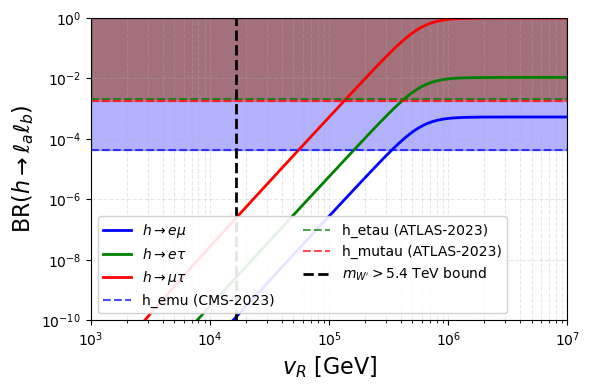


Summary at vR = 1e4 GeV:
  BR(h → eμ)  = 1.591e-11
  BR(h → eτ)  = 3.235e-10
  BR(h → μτ)  = 2.992e-08

Summary at vR = 1e5 GeV:
  BR(h → eμ)  = 2.265e-07
  BR(h → eτ)  = 4.604e-06
  BR(h → μτ)  = 4.267e-04


In [11]:
# Plot BR(h → ℓₐℓᵦ) vs vR for all three channels
# Fixed parameters: YR and muX
# Variable: vR in range [1e3, 1e6] GeV

# Define parameter values
YR_fixed = 1e-1       # Fixed Yukawa coupling
muX_fixed = 1e-3    # Fixed singlet mass (GeV)
vR_scan = np.logspace(3, 7, 100)  # vR from 1e3 to 1e6 GeV

print("Calculating BR for all LFV Higgs decay channels...")
print(f"Parameters: YR = {YR_fixed}, muX = {muX_fixed:.1e} GeV")
print(f"Scanning vR from {vR_scan[0]:.1e} to {vR_scan[-1]:.1e} GeV")
print("="*60)

# Calculate branching ratios for each channel
print("Calculating h → eμ...")
BR_h_emu = h_emu_calc.scan_vR(vR_scan, YR_fixed, muX_fixed)

print("Calculating h → eτ...")
BR_h_etau = h_etau_calc.scan_vR(vR_scan, YR_fixed, muX_fixed)

print("Calculating h → μτ...")
BR_h_mutau = h_mutau_calc.scan_vR(vR_scan, YR_fixed, muX_fixed)

print("✓ All calculations complete!")
print("="*60)

# Create the plot
fig, ax = plt.subplots(figsize=(6, 4))

# Plot each channel
ax.plot(vR_scan, BR_h_emu, 'b-', linewidth=2, label=r'$h \to e\mu$')
ax.plot(vR_scan, BR_h_etau, 'g-', linewidth=2, label=r'$h \to e\tau$')
ax.plot(vR_scan, BR_h_mutau, 'r-', linewidth=2, label=r'$h \to \mu\tau$')

# Add experimental bounds
exp_colors = {'h_emu': 'blue', 'h_etau': 'green', 'h_mutau': 'red'}
for channel, bounds in HiggsTolalbCalculator.EXPERIMENTAL_BOUND.items():
    color = exp_colors.get(channel, 'gray')
    for exp_name, bound_value in bounds.items():
        if 'ATLAS-2023' in exp_name or 'CMS-2023' in exp_name:
            linestyle = '--'
            alpha = 0.3
        #else:
        #    linestyle = ':'
        #    alpha = 0.2
        
            ax.axhline(bound_value, color=color, linestyle=linestyle, alpha=0.7, 
                   linewidth=1.5, label=f'{channel} ({exp_name})')
            # Shade excluded region
            ax.fill_between(vR_scan, bound_value, 1, color=color, alpha=alpha)

# Add W' mass bound
ax.axvline(vR_min, color='black', linestyle='--', linewidth=2, 
           label=r"$m_{W'} > 5.4$ TeV bound")

# Formatting
ax.set_xlabel(r"$v_R$ [GeV]", fontsize=16)
ax.set_ylabel(r"$\mathrm{BR}(h \to \ell_a \ell_b)$", fontsize=16)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(vR_scan[0], vR_scan[-1])
ax.set_ylim(1e-10, 1)
ax.grid(True, which="both", ls="--", alpha=0.3)

# Title with parameters
#ax.set_title(f"LFV Higgs Decays: $Y_R = {YR_fixed}$, $\mu_X = {muX_fixed:.1e}$ GeV", 
#             fontsize=14, pad=15)

# Legend
ax.legend(loc='best', fontsize=10, ncol=2, framealpha=0.9)

plt.tight_layout()
plt.savefig("LFV_Higgs_Decays_DLRSM.png", dpi=300)
plt.show()

# Print summary statistics
print("\nSummary at vR = 1e4 GeV:")
print(f"  BR(h → eμ)  = {BR_h_emu[np.argmin(np.abs(vR_scan - 1e4))]:.3e}")
print(f"  BR(h → eτ)  = {BR_h_etau[np.argmin(np.abs(vR_scan - 1e4))]:.3e}")
print(f"  BR(h → μτ)  = {BR_h_mutau[np.argmin(np.abs(vR_scan - 1e4))]:.3e}")

print(f"\nSummary at vR = 1e5 GeV:")
print(f"  BR(h → eμ)  = {BR_h_emu[np.argmin(np.abs(vR_scan - 1e5))]:.3e}")
print(f"  BR(h → eτ)  = {BR_h_etau[np.argmin(np.abs(vR_scan - 1e5))]:.3e}")
print(f"  BR(h → μτ)  = {BR_h_mutau[np.argmin(np.abs(vR_scan - 1e5))]:.3e}")


## 8. μ → eγ Branching Ratio Calculations

Compute branching ratios for muon to electron-gamma decay.

In [12]:
class lbTolaGammaCalculator:
    """Calculate BR(ℓb → ℓaγ) in DLRSM"""
    
    # Experimental upper bounds (95% CL)
    EXPERIMENTAL_BOUND = {
        'mutoegamma':{
            'MEG-II-2025': 1.5e-13,      # arXiv:2310.12614
            'MEG-II-future': 6e-14       # Projected sensitivity
        },
        'tautoegamma':{
            'BaBar-2010': 3.3e-8,        # arXiv:0908.2381
            'Belle-II-2024': 3e-9        # Projected sensitivity
        },
        'tautomugamma':{
            'Belle-2010': 4.2e-8,        # arXiv:0908.2381
            'Belle-II-2024': 1.0e-9      # Projected sensitivity
        }
    }
    
    # Total decay widths (PDG 2024)
    TOTAL_WIDTHS = {
        1: 2.996e-19,  # μ total width (GeV)
        2: 2.267e-12   # τ total width (GeV)
    }
    
    def __init__(self, sm_params: StandardModelParameters,
                 dlrsm_params: DLRSMParameters,
                 nu_params: NeutrinoParameters,
                 nu_mixing: NeutrinoMixingManager,
                 ff_manager: FormFactorManager,
                 lepton_a: int,
                 lepton_b: int):
        """
        Initialize calculator for ℓb → ℓaγ decay
        
        Parameters:
        -----------
        lepton_a : int
            Final state lepton flavor index (0=e, 1=μ, 2=τ)
        lepton_b : int
            Initial state lepton flavor index (1=μ, 2=τ)
        """
        self.sm = sm_params
        self.dlrsm = dlrsm_params
        self.nu = nu_params
        self.mixing = nu_mixing
        self.ff_mgr = ff_manager
        self.lepton_a = lepton_a
        self.lepton_b = lepton_b
        
        # Get lepton masses
        self.mla = sm_params.lepton_masses[lepton_a]
        self.mlb = sm_params.lepton_masses[lepton_b]
        
        # Setup approximate form factors
        self._setup_approximate_formfactors()
        
        # Vectorize width calculation
        self.width_meg_vec = np.vectorize(meg.width_mu_to_e_gamma)
        
        lepton_names = ['e', 'μ', 'τ']
        print(f"✓ {lepton_names[lepton_b]} → {lepton_names[lepton_a]}γ calculator initialized")
    
    def _setup_approximate_formfactors(self):
        """Setup analytic approximations for heavy mass limit"""
        print("Setting up μ → eγ form factors with heavy mass approximations...")
        
        # Define approximation variables
        t, ms, mf = symbols('t m_s, m_f', positive=True)
        
        # Scalar contributions (for HR, GL, GR)
        c1_lim = (t**2 - 2*t*log(t) - 1) / (2*ms**2*(t-1)**3)
        c11_lim = -((t**3 - 6*t**2 + 3*t + 6*t*log(t) + 2) / (6*ms**2*(t-1)**4))
        c12_lim = (-2*t**3 - 3*t**2 + 6*t**2*log(t) + 6*t - 1) / (12*ms**2*(t-1)**4)
        
        # Vector contributions (for W, W2)
        c0_limW = (t - t*log(t) - 1) / (ms**2*(t-1)**2)
        c1_limW = (t - t*log(t) - 1) / (ms**2*(t-1)**2)
        c11_limW = -((t**3 - 6*t**2 + 3*t + 6*t*log(t) + 2) / (6*ms**2*(t-1)**4))
        c12_limW = (11*t**3 - 6*t**3*log(t) - 18*t**2 + 9*t - 2) / (18*ms**2*(t-1)**4)
        c22_limW = -((t**3 - 6*t**2 + 3*t + 6*t*log(t) + 2) / (6*ms**2*(t-1)**4))
        
        # Build approximation dictionaries
        mla, mlb, mni = self.ff_mgr.mla, self.ff_mgr.mlb, self.ff_mgr.mni
        
        self.scalar_approx = lambda mS: {
            C1_sym(mla**2, mlb**2, 0, mS**2, mni**2, mS**2): 
                c1_lim.subs(t, mni**2/mS**2).subs(ms, mS).factor(),
            C11_sym(mla**2, mlb**2, 0, mS**2, mni**2, mS**2): 
                c11_lim.subs(t, mni**2/mS**2).subs(ms, mS).factor(),
            C12_sym(0, mla**2, mlb**2, mS**2, mS**2, mni**2): 
                c12_lim.subs(t, mni**2/mS**2).subs(ms, mS).factor()
        }
        
        self.vector_approx = lambda mV: {
            C0_sym(0, mla**2, mlb**2, mV**2, mV**2, mni**2): 
                c0_limW.subs(t, mni**2/mV**2).subs(ms, mV).factor(),
            C1_sym(0, mla**2, mlb**2, mV**2, mV**2, mni**2): 
                c1_limW.subs(t, mni**2/mV**2).subs(ms, mV).factor(),
            C1_sym(mla**2, mlb**2, 0, mV**2, mni**2, mV**2): 
                c1_limW.subs(t, mni**2/mV**2).subs(ms, mV).factor(),
            C11_sym(mla**2, mlb**2, 0, mV**2, mni**2, mV**2): 
                c11_limW.subs(t, mni**2/mV**2).subs(ms, mV).factor(),
            C12_sym(0, mla**2, mlb**2, mV**2, mV**2, mni**2): 
                c12_limW.subs(t, mni**2/mV**2).subs(ms, mV).factor(),
            C22_sym(0, mla**2, mlb**2, mV**2, mV**2, mni**2): 
                c22_limW.subs(t, mni**2/mV**2).subs(ms, mV).factor()
        }
        
        # Process MEG form factors
        self._process_meg_formfactors()
        
        print("✓ Analytic approximations applied")
    
    def _process_meg_formfactors(self):
        """Process and sum MEG form factors"""
        # Map contributions to masses
        contribution_mass = {
            'Wpm': mW1,
            'W2pm': mW2,
            'GLpm': mW1,
            'GRpm': mW2,
            'HRpm': mHR
        }
        
        # Sum over neutrinos for each contribution
        mll = symbols(r'm_e m_\mu m_\tau', positive=True)
        a_idx, b_idx = self.lepton_a, self.lepton_b  # lb → la gamma
        
        sigmaL_total = 0
        sigmaR_total = 0
        
        for contribution, formfactor in symbolic_formfactor_meg.items():
            # Apply substitutions
            ffL_sub = formfactor['sigmaL'].subs(self.ff_mgr.symbolic_changes)
            ffR_sub = formfactor['sigmaR'].subs(self.ff_mgr.symbolic_changes)
            
            # Apply approximations
            if contribution in ['HRpm', 'GLpm', 'GRpm']:
                ffL = ffL_sub.subs(self.scalar_approx(contribution_mass[contribution]))
                ffR = ffR_sub.subs(self.scalar_approx(contribution_mass[contribution]))
            elif contribution in ['Wpm', 'W2pm']:
                ffL = ffL_sub.subs(self.vector_approx(contribution_mass[contribution]))
                ffR = ffR_sub.subs(self.vector_approx(contribution_mass[contribution]))
            else:
                continue
            
            # Sum over 9 neutrinos
            for r in range(9):
                subs = self._one_neutrino_subs_meg(r, a_idx, b_idx, mll)
                sigmaL_total += ffL.subs(subs)
                sigmaR_total += ffR.subs(subs)
        
        # Apply numerical values and create lambdified functions
        numeric_subs = {
            mll[0]: self.sm.me,
            mll[1]: self.sm.mmu,
            mll[2]: self.sm.mtau,
            mW1: self.sm.mW,
            mZ1_sym: self.sm.mZ,
            k1: self.sm.k1,
            epsilon: k1 / vR
        }
        
        # Apply mass degeneracy and PMNS
        mass_degen = {M2m: M1m, M3m: M1m, M1p: M1m, M2p: M1m, M3p: M1m}
        
        sigmaL_num = sigmaL_total.subs(numeric_subs).subs(mass_degen).subs(
            self.mixing.unu_substitutions
        )
        sigmaR_num = sigmaR_total.subs(numeric_subs).subs(mass_degen).subs(
            self.mixing.unu_substitutions
        )
        
        # Create lambdified functions
        args = (m1, m2, m3, M1m, mHR, mW2, k1, vR, muX)
        self.sigmaL_func = lambdify(args, sigmaL_num, modules=['numpy'])
        self.sigmaR_func = lambdify(args, sigmaR_num, modules=['numpy'])
    
    def _one_neutrino_subs_meg(self, nu_idx: int, a: int, b: int, mll) -> Dict:
        """Build substitution for MEG with one neutrino"""
        neutrino_masses = [m1, m2, m3, M1m, M2m, M3m, M1p, M2p, M3p]
        elements = self.ff_mgr.symbolic_elements
        mixing = self.mixing.mixing_matrices
        
        return {
            self.ff_mgr.mla: mll[a],
            self.ff_mgr.mlb: mll[b],
            self.ff_mgr.mni: neutrino_masses[nu_idx],
            elements['Kai']: mixing['K'][a, nu_idx],
            elements['Kbi']: mixing['K'][b, nu_idx],
            elements['Kaic']: conjugate(mixing['K'][a, nu_idx]),
            elements['Kbic']: conjugate(mixing['K'][b, nu_idx]),
            elements['QRai']: mixing['QR'][a, nu_idx],
            elements['QRbi']: mixing['QR'][b, nu_idx],
            elements['QRaic']: conjugate(mixing['QR'][a, nu_idx]),
            elements['QRbic']: conjugate(mixing['QR'][b, nu_idx]),
            elements['QLai']: mixing['QL'][a, nu_idx],
            elements['QLbi']: mixing['QL'][b, nu_idx],
            elements['QLaic']: conjugate(mixing['QL'][a, nu_idx]),
            elements['QLbic']: conjugate(mixing['QL'][b, nu_idx]),
            elements['TRLia']: mixing['TRL'][nu_idx, a],
            elements['TRLib']: mixing['TRL'][nu_idx, b],
            elements['TRLiac']: conjugate(mixing['TRL'][nu_idx, a]),
            elements['TRLibc']: conjugate(mixing['TRL'][nu_idx, b]),
            elements['Jai']: mixing['J'][a, nu_idx],
            elements['Jbi']: mixing['J'][b, nu_idx],
            elements['Jaic']: conjugate(mixing['J'][a, nu_idx]),
            elements['Jbic']: conjugate(mixing['J'][b, nu_idx]),
        }
    
    def calculate_branching_ratio(self, vR: float, YR: float, muX: float) -> float:
        """Calculate BR(ℓb → ℓaγ) at a parameter point"""
        # Derived masses
        M1m_val = YR * vR / np.sqrt(2)
        mHR_val = np.sqrt(self.dlrsm.alpha23 * (self.sm.k1**2 + vR**2))
        mW2_val = np.sqrt((self.sm.mW**2 / self.sm.k1**2) * (self.sm.k1**2 + vR**2))
        
        # Evaluate form factors
        sigmaL = self.sigmaL_func(
            self.nu.masses_GeV[0], self.nu.masses_GeV[1], self.nu.masses_GeV[2],
            M1m_val, mHR_val, mW2_val, self.sm.k1, vR, muX
        )
        sigmaR = self.sigmaR_func(
            self.nu.masses_GeV[0], self.nu.masses_GeV[1], self.nu.masses_GeV[2],
            M1m_val, mHR_val, mW2_val, self.sm.k1, vR, muX
        )
        
        # Calculate width using the correct decaying lepton mass
        width = meg.width_mu_to_e_gamma(self.mlb, sigmaL, sigmaR)
        
        # Get total width for the decaying lepton
        if self.lepton_b not in self.TOTAL_WIDTHS:
            raise ValueError(f"Invalid lepton_b = {self.lepton_b} (must be 1 for μ or 2 for τ)")
        
        total_width = self.TOTAL_WIDTHS[self.lepton_b]
        
        return width / total_width
    
    def scan_vR(self, vR_values: np.ndarray, YR: float, muX: float) -> np.ndarray:
        """Scan over vR values"""
        BR_values = np.zeros_like(vR_values)
        
        for idx, vR in enumerate(vR_values):
            BR_values[idx] = self.calculate_branching_ratio(vR, YR, muX)
        
        return BR_values
    
    def scan_YR(self, vR: float, YR_values: np.ndarray, muX: float) -> np.ndarray:
        """Scan over YR values"""
        BR_values = np.zeros_like(YR_values)
        
        for idx, YR in enumerate(YR_values):
            BR_values[idx] = self.calculate_branching_ratio(vR, YR, muX)
        
        return BR_values

    def scan_2d(self, vR_values: np.ndarray, YR_values: np.ndarray,
                muX: float) -> np.ndarray:
        """2D parameter scan over (vR, YR)"""
        vR_grid, YR_grid = np.meshgrid(vR_values, YR_values)
        BR_grid = np.zeros_like(vR_grid)
        
        total = vR_grid.size
        lepton_names = ['e', 'μ', 'τ']
        channel_name = f"{lepton_names[self.lepton_b]} → {lepton_names[self.lepton_a]}γ"
        print(f"Running 2D scan for {channel_name}: {len(vR_values)}×{len(YR_values)} = {total} points...")
        
        for i in range(vR_grid.shape[0]):
            for j in range(vR_grid.shape[1]):
                BR_grid[i, j] = self.calculate_branching_ratio(
                    vR_grid[i, j], YR_grid[i, j], muX
                )
            
            if (i+1) % 10 == 0:
                print(f"  Progress: {(i+1)*vR_grid.shape[1]}/{total} points")
        
        print(f"✓ 2D scan for {channel_name} complete")
        return BR_grid


# Create calculators for all ℓb → ℓaγ channels
print("\nInitializing ℓb → ℓaγ calculators:")
print("="*60)

mutoegamma_calc = lbTolaGammaCalculator(
    sm_params, dlrsm_params, nu_params, nu_mixing, ff_manager, lepton_a=0, lepton_b=1
)
tautoegamma_calc = lbTolaGammaCalculator(
    sm_params, dlrsm_params, nu_params, nu_mixing, ff_manager, lepton_a=0, lepton_b=2
)
tautomugamma_calc = lbTolaGammaCalculator(
    sm_params, dlrsm_params, nu_params, nu_mixing, ff_manager, lepton_a=1, lepton_b=2
)

print("="*60)


Initializing ℓb → ℓaγ calculators:
Setting up μ → eγ form factors with heavy mass approximations...
✓ Analytic approximations applied
✓ μ → eγ calculator initialized
Setting up μ → eγ form factors with heavy mass approximations...
✓ Analytic approximations applied
✓ μ → eγ calculator initialized
Setting up μ → eγ form factors with heavy mass approximations...
✓ Analytic approximations applied
✓ τ → eγ calculator initialized
Setting up μ → eγ form factors with heavy mass approximations...
✓ Analytic approximations applied
✓ τ → eγ calculator initialized
Setting up μ → eγ form factors with heavy mass approximations...
✓ Analytic approximations applied
✓ τ → μγ calculator initialized
✓ Analytic approximations applied
✓ τ → μγ calculator initialized


Calculating BR for all radiative LFV decay channels...
Parameters: YR = 1, muX = 1.0e-06 GeV
Scanning vR from 1.0e+03 to 1.0e+07 GeV
Calculating μ → eγ...
Calculating τ → eγ...
Calculating τ → μγ...
✓ All calculations complete!


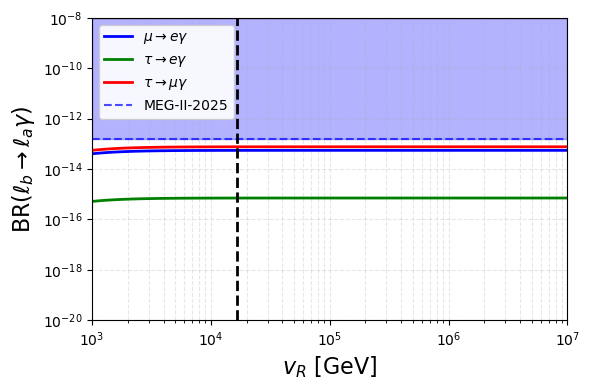


Summary at vR = 1e4 GeV:
  BR(μ → eγ)  = 5.465e-14
  BR(τ → eγ)  = 7.018e-16
  BR(τ → μγ)  = 7.571e-14

Summary at vR = 1e5 GeV:
  BR(μ → eγ)  = 5.501e-14
  BR(τ → eγ)  = 7.065e-16
  BR(τ → μγ)  = 7.624e-14

Comparison with Experimental Bounds:

μ → eγ:
  MEG-II-2025: 1.500e-13
  MEG-II-future: 6.000e-14

τ → eγ:
  BaBar-2010: 3.300e-08
  Belle-II-2024: 3.000e-09

τ → μγ:
  Belle-2010: 4.200e-08
  Belle-II-2024: 1.000e-09


In [13]:
# Plot BR(ℓb → ℓaγ) vs vR for all three channels
# Fixed parameters: YR and muX
# Variable: vR in range [1e3, 1e6] GeV

# Define parameter values (using same as Higgs for comparison)
YR_fixed = 1       # Fixed Yukawa coupling
muX_fixed = 1e-6    # Fixed singlet mass (GeV)
vR_scan = np.logspace(3, 7, 100)  # vR from 1e3 to 1e7 GeV

print("Calculating BR for all radiative LFV decay channels...")
print(f"Parameters: YR = {YR_fixed}, muX = {muX_fixed:.1e} GeV")
print(f"Scanning vR from {vR_scan[0]:.1e} to {vR_scan[-1]:.1e} GeV")
print("="*60)

# Calculate branching ratios for each channel
print("Calculating μ → eγ...")
BR_mutoegamma = mutoegamma_calc.scan_vR(vR_scan, YR_fixed, muX_fixed)

print("Calculating τ → eγ...")
BR_tautoegamma = tautoegamma_calc.scan_vR(vR_scan, YR_fixed, muX_fixed)

print("Calculating τ → μγ...")
BR_tautomugamma = tautomugamma_calc.scan_vR(vR_scan, YR_fixed, muX_fixed)

print("✓ All calculations complete!")
print("="*60)

# Create the plot
fig, ax = plt.subplots(figsize=(6, 4))

# Plot each channel
ax.plot(vR_scan, BR_mutoegamma, 'b-', linewidth=2, label=r'$\mu \to e\gamma$')
ax.plot(vR_scan, BR_tautoegamma, 'g-', linewidth=2, label=r'$\tau \to e\gamma$')
ax.plot(vR_scan, BR_tautomugamma, 'r-', linewidth=2, label=r'$\tau \to \mu\gamma$')

# Add experimental bounds
exp_colors = {'mutoegamma': 'blue', 'tautoegamma': 'green', 'tautomugamma': 'red'}
for channel, bounds in lbTolaGammaCalculator.EXPERIMENTAL_BOUND.items():
    color = exp_colors.get(channel, 'gray')
    for exp_name, bound_value in bounds.items():
        if 'MEG-II-2025' in exp_name or 'BaBar-2010' in exp_name or 'Belle-2010' in exp_name:
            linestyle = '--'
            alpha = 0.3
        #else:
        #    linestyle = ':'
        #    alpha = 0.2
        
            ax.axhline(bound_value, color=color, linestyle=linestyle, alpha=0.7, 
                   linewidth=1.5, label=f'{exp_name}')
            # Shade excluded region
            ax.fill_between(vR_scan, bound_value, 1e-8, color=color, alpha=alpha)

# Add W' mass bound
ax.axvline(vR_min, color='black', linestyle='--', linewidth=2, 
           label=r"$m_{W'} > 5.4$ TeV bound")

# Formatting
ax.set_xlabel(r"$v_R$ [GeV]", fontsize=16)
ax.set_ylabel(r"$\mathrm{BR}(\ell_b \to \ell_a \gamma)$", fontsize=16)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(vR_scan[0], vR_scan[-1])
ax.set_ylim(1e-20, 1e-8)
ax.grid(True, which="both", ls="--", alpha=0.3)

# Title with parameters
#ax.set_title(f"Radiative LFV Decays: $Y_R = {YR_fixed}$, $\mu_X = {muX_fixed:.1e}$ GeV", 
#             fontsize=14, pad=15)

# Legend (split into two to avoid overcrowding)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:4], labels[:4], loc='upper left', fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.savefig("LFV_Radiative_Decays_DLRSM.png", dpi=300)
plt.show()

# Print summary statistics
print("\nSummary at vR = 1e4 GeV:")
idx_1e4 = np.argmin(np.abs(vR_scan - 1e4))
print(f"  BR(μ → eγ)  = {BR_mutoegamma[idx_1e4]:.3e}")
print(f"  BR(τ → eγ)  = {BR_tautoegamma[idx_1e4]:.3e}")
print(f"  BR(τ → μγ)  = {BR_tautomugamma[idx_1e4]:.3e}")

print(f"\nSummary at vR = 1e5 GeV:")
idx_1e5 = np.argmin(np.abs(vR_scan - 1e5))
print(f"  BR(μ → eγ)  = {BR_mutoegamma[idx_1e5]:.3e}")
print(f"  BR(τ → eγ)  = {BR_tautoegamma[idx_1e5]:.3e}")
print(f"  BR(τ → μγ)  = {BR_tautomugamma[idx_1e5]:.3e}")

# Compare with experimental bounds
print("\n" + "="*60)
print("Comparison with Experimental Bounds:")
print("="*60)
def _channel_to_key(name: str) -> str:
    # Robustly convert human-readable channel names with Greek letters to the dict keys
    s = name
    s = s.replace('μ', 'mu').replace('τ', 'tau')
    s = s.replace('→', 'to').replace('->', 'to')
    s = s.replace(' ', '')
    s = s.replace('γ', 'gamma')
    return s.lower()

for channel_name, calc in [('μ → eγ', mutoegamma_calc), 
                           ('τ → eγ', tautoegamma_calc), 
                           ('τ → μγ', tautomugamma_calc)]:
    print(f"\n{channel_name}:")
    channel_key = _channel_to_key(channel_name)
    bounds_dict = lbTolaGammaCalculator.EXPERIMENTAL_BOUND.get(channel_key)
    if bounds_dict is None:
        print(f"  Warning: no experimental bounds available for key '{channel_key}'")
        continue
    for exp_name, bound in bounds_dict.items():
        print(f"  {exp_name}: {bound:.3e}")


## 9. Visualization Functions

Create publication-quality plotting functions.

In [14]:
import numpy as np

def latex_sci_label(x, var='x'):
    exponent = int(np.floor(np.log10(abs(x))))
    coeff = x / 10**exponent
    if x==1:
        return 1
    elif np.isclose(coeff, 1.0):
        #return f"${var} = 10^{{{exponent}}}$"
        return f"10^{{{exponent}}}"
    else:
        #return f"${var} = {coeff:.2f} \\times 10^{{{exponent}}}$"
        return f"{coeff:.2f} \\times 10^{{{exponent}}}$"

# Example usage
x = 1#0.0001
label = latex_sci_label(x)
print(label)  # Output: "$x = 10^{-3}$"

1


In [15]:
mutoegamma_calc.YR_PERTURBATIVE_LIMIT = h_mutau_calc.YR_PERTURBATIVE_LIMIT
mutoegamma_calc.WPRIME_MASS_BOUND = h_mutau_calc.WPRIME_MASS_BOUND

In [16]:
def plot_h_lalb_br(
    vR_values: np.ndarray,
    h_lalb_calc: HiggsTolalbCalculator,
    YR: float = None,
    muX: float = None,
    YR_list: list = None,
    muX_list: list = None,
    vR_min: float = None,
    experimental_bound: dict = None,
    ax: Optional[plt.Axes] = None,
    save_path: str = None,
    **kwargs
):
    """
    Plot BR(h → ℓₐℓᵦ) vs vR for fixed YR or muX, and optionally for multiple values of YR or muX.
    
    Parameters:
    -----------
    vR_values : np.ndarray
        Array of vR values to scan
    h_lalb_calc : HiggsTolalbCalculator
        Calculator instance for the specific channel (e.g., h_emu_calc, h_etau_calc, h_mutau_calc)
    YR : float, optional
        Fixed YR value (used with muX_list)
    muX : float, optional
        Fixed muX value (used with YR_list)
    YR_list : list, optional
        List of YR values to plot (requires muX to be set)
    muX_list : list, optional
        List of muX values to plot (requires YR to be set)
    vR_min : float, optional
        Minimum vR from W' mass bound (vertical line)
    experimental_bound : dict, optional
        Dictionary of experimental bounds {experiment_name: bound_value}
    ax : plt.Axes, optional
        Matplotlib axes to plot on (creates new if None)
    save_path : str, optional
        Path to save the figure
    **kwargs : dict
        Additional arguments passed to ax.plot()
    
    Returns:
    --------
    ax : plt.Axes
        The matplotlib axes object
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    # Get lepton names for labels
    lepton_names = ['e', 'μ', 'τ']
    la_name = lepton_names[h_lalb_calc.lepton_a]
    lb_name = lepton_names[h_lalb_calc.lepton_b]
    channel_label = f"{la_name}{lb_name}"

    BR_lines = None
    # Plot for multiple muX values (fix YR)
    if muX_list is not None and YR is not None:
        BR_lines = []
        for muX_val in muX_list:
            BR_values = h_lalb_calc.scan_vR(vR_values, YR, muX_val)
            line = ax.plot(vR_values, BR_values, label=fr"$\mu_X={latex_sci_label(muX_val)}$", **kwargs)
            BR_lines.append(line[0])
            
    # Plot for multiple YR values (fix muX)
    elif YR_list is not None and muX is not None:
        BR_lines = []
        for YR_val in YR_list:
            BR_values = h_lalb_calc.scan_vR(vR_values, YR_val, muX)
            line = ax.plot(vR_values, BR_values, label=f"$Y_R={latex_sci_label(YR_val)}$", **kwargs)
            BR_lines.append(line[0])
            
        # Special case: perturbativity limit
        if h_lalb_calc.YR_PERTURBATIVE_LIMIT not in YR_list:
            BR_values_pert = h_lalb_calc.scan_vR(vR_values, h_lalb_calc.YR_PERTURBATIVE_LIMIT, muX)
            line = ax.plot(vR_values, BR_values_pert,'--', color='purple', label=fr"$Y_R=\sqrt{{6 \pi}}$", **kwargs)
            BR_lines.append(line[0])
            # Shaded region above perturbativity limit
            plt.fill_between(vR_values, BR_values_pert, 1, color='purple', alpha=0.5)

    # Default: single curve
    elif YR is not None and muX is not None:
        BR_values = h_lalb_calc.scan_vR(vR_values, YR, muX)
        ax.plot(vR_values, BR_values, label=fr"$Y_R={YR}$, " + fr"$\mu_X={muX}$", **kwargs)

    # Add legend for parameter variations
    if BR_lines is not None:
        legend1 = ax.legend(handles=BR_lines, loc='lower left', fontsize=10, ncol=2)
        ax.add_artist(legend1)
        
    # Axis labels and formatting
    ax.set_xlabel(r"$v_R$ [GeV]", fontsize=14)
    ax.set_ylabel(fr"$\mathrm{{BR}}(h \to {channel_label})$", fontsize=14)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True, which="both", ls="--", alpha=0.5)
    
    # Plot experimental bounds
    bound_lines = []
    if experimental_bound is not None:
        for collider, exp_bound in experimental_bound.items():
            if collider == 'ATLAS-2023':
                # Draw experimental bound line
                line = ax.axhline(exp_bound, color="red", ls="--", label=collider)
                bound_lines.append(line)
                # Shaded excluded region above bound
                ax.fill_between(vR_values, exp_bound, 1, color="red", alpha=0.1)
            else:
                # Draw experimental bound line with different color
                line = ax.axhline(exp_bound, ls="--", color=plt.cm.winter_r(np.random.rand()), label=collider)
                bound_lines.append(line)
                
    # W' mass bound vertical line
    if vR_min is not None:
        line = ax.axvline(vR_min, color="black", ls="--", label=r"$m_{W'}$ bound")
        bound_lines.append(line)
        
    # Add legend for bounds
    if bound_lines:
        legend2 = ax.legend(handles=bound_lines, loc='lower right', fontsize=10)
        ax.add_artist(legend2)
        
    # Set axis limits
    ax.set_xlim(left=vR_values[0], right=vR_values[-1])
    ax.set_ylim(ymax=1)
    
    # Save figure if requested
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
        
    return ax

In [17]:
def plot_lbtolagamma_br(
    vR_values: np.ndarray,
    lbtolagamma_calc: lbTolaGammaCalculator,
    YR: float = None,
    muX: float = None,
    YR_list: list = None,
    muX_list: list = None,
    vR_min: float = None,
    experimental_bound: dict = None,
    ax: Optional[plt.Axes] = None,
    save_path: str = None,
    **kwargs
):
    """
    Plot BR(ℓb → ℓaγ) vs vR for fixed YR or muX, and optionally for multiple values of YR or muX.
    
    Parameters:
    -----------
    vR_values : np.ndarray
        Array of vR values to scan
    lbtolagamma_calc : lbTolaGammaCalculator
        Calculator instance for the specific channel (e.g., mutoegamma_calc, tautoegamma_calc)
    YR : float, optional
        Fixed YR value (used with muX_list)
    muX : float, optional
        Fixed muX value (used with YR_list)
    YR_list : list, optional
        List of YR values to plot (requires muX to be set)
    muX_list : list, optional
        List of muX values to plot (requires YR to be set)
    vR_min : float, optional
        Minimum vR from W' mass bound (vertical line)
    experimental_bound : dict, optional
        Dictionary of experimental bounds {experiment_name: bound_value}
    ax : plt.Axes, optional
        Matplotlib axes to plot on (creates new if None)
    save_path : str, optional
        Path to save the figure
    **kwargs : dict
        Additional arguments passed to ax.plot()
    
    Returns:
    --------
    ax : plt.Axes
        The matplotlib axes object
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    # Get lepton names for labels
    lepton_names = ['e', 'μ', 'τ']
    la_name = lepton_names[lbtolagamma_calc.lepton_a]
    lb_name = lepton_names[lbtolagamma_calc.lepton_b]
    channel_label = f"{lb_name} \\to {la_name}\\gamma"

    BR_lines = None
    # Plot for multiple muX values (fix YR)
    if muX_list is not None and YR is not None:
        BR_lines = []
        for muX_val in muX_list:
            BR_values = lbtolagamma_calc.scan_vR(vR_values, YR, muX_val)
            line = ax.plot(vR_values, BR_values, label=fr"$\mu_X={latex_sci_label(muX_val)}$", **kwargs)
            BR_lines.append(line[0])
            
    # Plot for multiple YR values (fix muX)
    elif YR_list is not None and muX is not None:
        BR_lines = []
        for YR_val in YR_list:
            BR_values = lbtolagamma_calc.scan_vR(vR_values, YR_val, muX)
            line = ax.plot(vR_values, BR_values, label=f"$Y_R={latex_sci_label(YR_val)}$", **kwargs)
            BR_lines.append(line[0])
            
        # Special case: perturbativity limit (if available)
        if hasattr(lbtolagamma_calc, 'YR_PERTURBATIVE_LIMIT'):
            if lbtolagamma_calc.YR_PERTURBATIVE_LIMIT not in YR_list:
                BR_values_pert = lbtolagamma_calc.scan_vR(vR_values, lbtolagamma_calc.YR_PERTURBATIVE_LIMIT, muX)
                line = ax.plot(vR_values, BR_values_pert, '--', color='purple', label=fr"$Y_R=\sqrt{{6 \pi}}$", **kwargs)
                BR_lines.append(line[0])
                # Shaded region above perturbativity limit
                plt.fill_between(vR_values, BR_values_pert, 1e-12, color='purple', alpha=0.5)
                
    # Default: single curve
    elif YR is not None and muX is not None:
        BR_values = lbtolagamma_calc.scan_vR(vR_values, YR, muX)
        line = ax.plot(vR_values, BR_values, label=fr"$Y_R={YR}$, $\mu_X={muX}$", **kwargs)
        BR_lines = [line[0]]
    
    # Add legend for parameter variations
    if BR_lines is not None:
        legend1 = ax.legend(handles=BR_lines, loc='lower left', fontsize=10, ncol=2)
        ax.add_artist(legend1)
        
    # Axis labels and formatting
    ax.set_xlabel(r"$v_R$ [GeV]", fontsize=14)
    ax.set_ylabel(fr"$\mathrm{{BR}}({channel_label})$", fontsize=14)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True, which="both", ls="--", alpha=0.5)
    
    # Plot experimental bounds
    bound_lines = []
    if experimental_bound is not None:
        for collider, exp_bound in experimental_bound.items():
            if 'MEG-II-2025' in collider or 'Belle-II-2024' in collider or 'BaBar-2010' in collider:
                # Current/past experimental bounds
                color = "red" if "MEG" in collider else "orange"
                line = ax.axhline(exp_bound, color=color, ls="--", label=collider)
                bound_lines.append(line)
                # Shaded excluded region above bound
                ax.fill_between(vR_values, exp_bound, 1e-12, color=color, alpha=0.1)
            else:
                # Future projections
                line = ax.axhline(exp_bound, ls=":", color=plt.cm.winter_r(np.random.rand()), label=collider)
                bound_lines.append(line)
                
    # W' mass bound vertical line
    if vR_min is not None:
        line_mWprime = ax.axvline(vR_min, color="black", ls="--", label=r"$m_{W'}$ bound")
        bound_lines.append(line_mWprime)
        
    # Add legend for bounds
    if bound_lines:
        legend2 = ax.legend(handles=bound_lines, loc='lower right', fontsize=10)
        ax.add_artist(legend2)
        
    # Set axis limits
    ax.set_xlim(left=vR_values[0], right=vR_values[-1])
    ax.set_ylim(ymax=1e-12)
    
    # Save figure if requested
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
        
    return ax

## LFV decays 

/tmp/ipykernel_65785/770857071.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BR_values[idx] = self.calculate_branching_ratio(vR, YR, muX)


Plot saved to h_mutau_br_vs_vR_muX_1e-6.png


<Axes: xlabel='$v_R$ [GeV]', ylabel='$\\mathrm{BR}(h \\to μτ)$'>

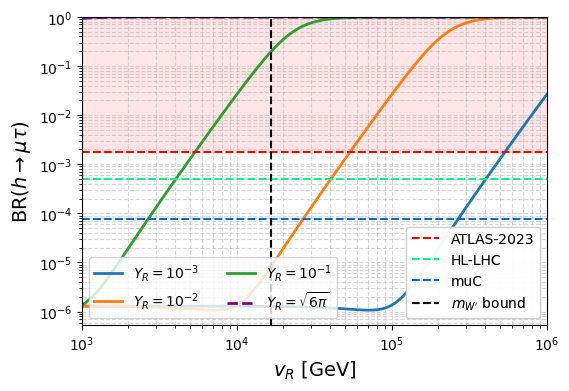

In [18]:
plot_h_lalb_br(
    vR_values=np.logspace(3, 6, 100),
    h_lalb_calc=h_mutau_calc,
    YR_list=[1e-3, 1e-2, 1e-1],
    muX=1e-6,
    vR_min=vR_min,
    experimental_bound=h_mutau_calc.EXPERIMENTAL_BOUND['h_mutau'],
    save_path="h_mutau_br_vs_vR_muX_1e-6.png",
    lw=2
)

Plot saved to meg_br_vs_vR_muX_1e-6.png


<Axes: xlabel='$v_R$ [GeV]', ylabel='$\\mathrm{BR}(μ \\to e\\gamma)$'>

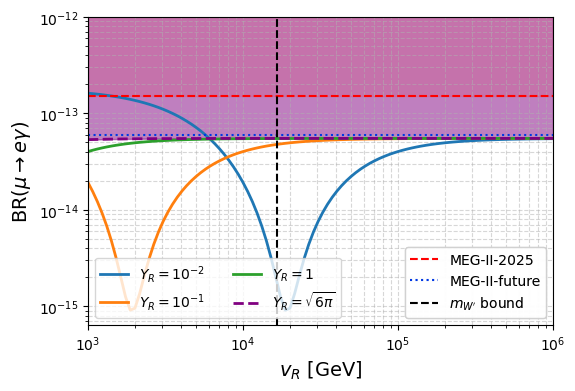

In [19]:
plot_lbtolagamma_br(
    vR_values=np.logspace(3, 6, 100),
    lbtolagamma_calc=mutoegamma_calc,
    YR_list=[1e-2, 1e-1, 1],
    muX=1e-6,
    vR_min=vR_min,
    experimental_bound=mutoegamma_calc.EXPERIMENTAL_BOUND['mutoegamma'],
    save_path="meg_br_vs_vR_muX_1e-6.png",
    lw=2
)

/tmp/ipykernel_65785/770857071.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BR_values[idx] = self.calculate_branching_ratio(vR, YR, muX)


Plot saved to h_mutau_br_vs_vR_YR_1.png


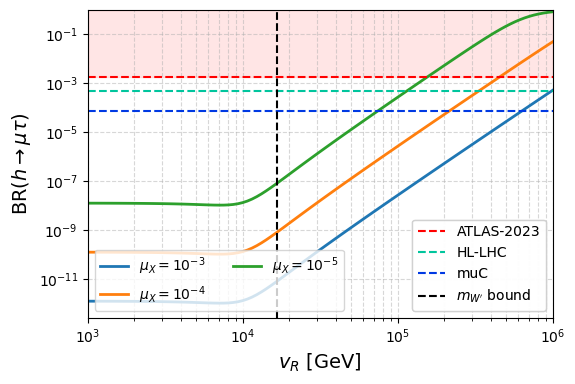

In [20]:
plot_h_lalb_br(
    vR_values=np.logspace(3, 6, 100),
    h_lalb_calc=h_mutau_calc,
    YR=1e-2,
    muX_list=[1e-3, 1e-4, 1e-5],
    vR_min=vR_min,
    experimental_bound=h_mutau_calc.EXPERIMENTAL_BOUND['h_mutau'],
    save_path="h_mutau_br_vs_vR_YR_1.png",
    lw=2
)
plt.show()

Plot saved to meg_br_vs_vR_YR_1.png


<Axes: xlabel='$v_R$ [GeV]', ylabel='$\\mathrm{BR}(μ \\to e\\gamma)$'>

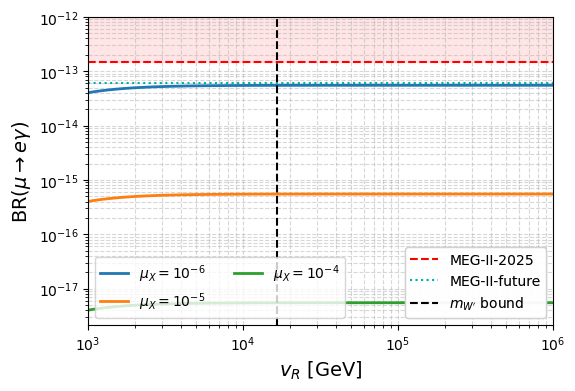

In [21]:
plot_lbtolagamma_br(
    vR_values=np.logspace(3, 6, 100),
    lbtolagamma_calc=mutoegamma_calc,
    YR=1.0,
    muX_list=[1e-6, 1e-5, 1e-4],
    vR_min=vR_min,
    experimental_bound=mutoegamma_calc.EXPERIMENTAL_BOUND['mutoegamma'],
    save_path="meg_br_vs_vR_YR_1.png",
    lw=2
)

## Parameter Scan

In [22]:
def montecarlo_scan_log(
    N_points: int,
    vR_range: tuple,
    YR_range: tuple,
    muX_range: tuple,
    higgs_calcs: dict,
    radiative_calcs: dict,
    nu_params: NeutrinoParameters,
    experimental_bounds: dict = None,
    vR_min: float = None,
    batch_size: int = 1000,
    verbose: bool = True,
    early_stopping: bool = True
):
    """
    Optimized Monte Carlo scan over (vR, YR, muX) parameter space using log-uniform sampling.
    Only keeps points allowed by ALL LFV experimental bounds (both Higgs and radiative decays).
    
    Optimizations:
    --------------
    - Pre-compute bounds and convert to arrays for vectorized comparisons
    - Cache calculator objects to avoid dictionary lookups
    - Early stopping: check most stringent bounds first
    - Vectorized masking for pre-filtering
    - Minimize exception handling overhead
    - Use structured numpy arrays for results
    
    Parameters:
    -----------
    N_points : int
        Total number of random points to sample
    vR_range : tuple
        Range for vR: (min, max) in GeV
    YR_range : tuple
        Range for YR: (min, max) dimensionless
    muX_range : tuple
        Range for muX: (min, max) in GeV
    higgs_calcs : dict
        Dictionary of Higgs LFV calculators: {'h_emu': calc, 'h_etau': calc, 'h_mutau': calc}
    radiative_calcs : dict
        Dictionary of radiative LFV calculators: {'mutoegamma': calc, 'tautoegamma': calc, 'tautomugamma': calc}
    nu_params : NeutrinoParameters
        Neutrino parameters
    experimental_bounds : dict, optional
        Dictionary with experimental bounds for all channels
        If None, uses current bounds from calculator classes
    vR_min : float, optional
        Minimum vR from W' mass bound. If None, uses vR_range[0]
    batch_size : int, optional
        Number of points to process in each batch (default: 1000)
    verbose : bool, optional
        Whether to print progress (default: True)
    early_stopping : bool, optional
        Check most stringent bounds first for faster rejection (default: True)
    
    Returns:
    --------
    numpy.ndarray
        Structured array with allowed points and branching ratios for all channels
    """
    if experimental_bounds is None:
        experimental_bounds = {
            # Higgs LFV decays (from cell 19)
            "h_emu": {
                'CMS-2023': 4.4e-5,
                'HL-LHC': 1.0e-5,
                'muC': 9.9e-6
            },
            "h_etau": {
                'ATLAS-2023': 2.0e-3,
                'HL-LHC': 5.0e-4,
                'muC': 8.4e-5
            },
            "h_mutau": {
                'ATLAS-2023': 1.8e-3,
                'HL-LHC': 5.0e-4,
                'muC': 7.7e-5
            },
            # Radiative LFV decays (from cell 22)
            "mutoegamma": {
                'MEG-II-2025': 1.5e-13,
                'MEG-II-future': 6e-14
            },
            "tautoegamma": {
                'BaBar-2010': 3.3e-8,
                'Belle-II-2024': 3e-9
            },
            "tautomugamma": {
                'Belle-2010': 4.2e-8,
                'Belle-II-2024': 1.0e-9
            }
        }
    
    if vR_min is None:
        vR_min = vR_range[0]
    
    # Pre-compute log ranges for faster sampling
    log_vR_min, log_vR_max = np.log10(vR_range[0]), np.log10(vR_range[1])
    log_YR_min, log_YR_max = np.log10(YR_range[0]), np.log10(YR_range[1])
    log_muX_min, log_muX_max = np.log10(muX_range[0]), np.log10(muX_range[1])
    
    # Get perturbativity limit
    YR_pert_limit = list(higgs_calcs.values())[0].YR_PERTURBATIVE_LIMIT
    
    # Extract and cache bounds (using most stringent current bounds)
    channel_names = ['h_emu', 'h_etau', 'h_mutau', 'mutoegamma', 'tautoegamma', 'tautomugamma']
    bounds_array = np.array([
        experimental_bounds["h_emu"]['CMS-2023'],
        experimental_bounds["h_etau"]['ATLAS-2023'],
        experimental_bounds["h_mutau"]['ATLAS-2023'],
        experimental_bounds["mutoegamma"]['MEG-II-2025'],
        experimental_bounds["tautoegamma"]['BaBar-2010'],
        experimental_bounds["tautomugamma"]['Belle-2010']
    ])
    
    # Sort channels by bound stringency (most stringent first) for early stopping
    if early_stopping:
        sorted_indices = np.argsort(bounds_array)
        channel_names_sorted = [channel_names[i] for i in sorted_indices]
        bounds_sorted = bounds_array[sorted_indices]
    else:
        channel_names_sorted = channel_names
        bounds_sorted = bounds_array
    
    # Cache calculator objects
    calc_cache = {}
    calc_cache.update(higgs_calcs)
    calc_cache.update(radiative_calcs)
    
    # Pre-allocate result list (more efficient than appending)
    results = []
    
    # Process in batches
    n_batches = (N_points + batch_size - 1) // batch_size
    
    if verbose:
        print("Experimental bounds used (ordered by stringency):")
        for ch, bound in zip(channel_names_sorted, bounds_sorted):
            print(f"  {ch}: {bound:.2e}")
        print()
    
    for batch_idx in range(n_batches):
        # Determine batch size (last batch may be smaller)
        current_batch_size = min(batch_size, N_points - batch_idx * batch_size)
        
        # Vectorized random sampling
        log_vR_samples = np.random.uniform(log_vR_min, log_vR_max, current_batch_size)
        log_YR_samples = np.random.uniform(log_YR_min, log_YR_max, current_batch_size)
        log_muX_samples = np.random.uniform(log_muX_min, log_muX_max, current_batch_size)
        
        vR_samples = 10 ** log_vR_samples
        YR_samples = 10 ** log_YR_samples
        muX_samples = 10 ** log_muX_samples
        
        # Pre-filter based on perturbativity and W' mass bound
        valid_mask = (YR_samples <= YR_pert_limit) & (vR_samples >= vR_min)
        valid_indices = np.where(valid_mask)[0]
        
        # Process only valid points
        for idx in valid_indices:
            vR = float(vR_samples[idx])
            YR = float(YR_samples[idx])
            muX = float(muX_samples[idx])
            
            try:
                # Calculate branching ratios with early stopping
                BR_values = {}
                passed = True
                
                for ch_name, bound in zip(channel_names_sorted, bounds_sorted):
                    calc = calc_cache[ch_name]
                    BR = calc.calculate_branching_ratio(vR, YR, muX)
                    BR_values[ch_name] = float(BR)
                    
                    # Early stopping: if this bound is violated, skip remaining channels
                    if early_stopping and BR >= bound:
                        passed = False
                        break
                
                # If early stopping didn't trigger, check all bounds
                if passed and not early_stopping:
                    passed = all(BR_values[ch] < bounds_array[i] 
                                for i, ch in enumerate(channel_names))
                
                if passed:
                    result_point = {
                        "vR": vR,
                        "YR": YR,
                        "muX": muX
                    }
                    # Reorder BR_values to match original channel order
                    for ch in channel_names:
                        result_point[ch] = BR_values[ch]
                    results.append(result_point)
                    
            except Exception as e:
                # Skip points that cause errors in calculation
                if verbose and len(results) == 0 and batch_idx == 0:
                    print(f"Warning: Error at point (vR={vR:.2e}, YR={YR:.2e}, muX={muX:.2e}): {str(e)[:50]}")
                continue
        
        # Print progress
        if verbose and (batch_idx + 1) % max(1, n_batches // 10) == 0:
            progress = ((batch_idx + 1) * batch_size) / N_points * 100
            print(f"Progress: {min(progress, 100):.1f}% ({len(results)} allowed points found)")
    
    if verbose:
        print(f"Scan complete: {len(results)}/{N_points} points passed constraints ({len(results)/N_points*100:.2f}%)")
    
    # Convert to structured numpy array for efficient storage and analysis
    if len(results) > 0:
        dtype = [(name, 'f8') for name in ['vR', 'YR', 'muX'] + channel_names]
        structured_results = np.array([tuple(d[k] for k in ['vR', 'YR', 'muX'] + channel_names) 
                                       for d in results], dtype=dtype)
        return structured_results
    else:
        # Return empty structured array with correct dtype
        dtype = [(name, 'f8') for name in ['vR', 'YR', 'muX'] + channel_names]
        return np.array([], dtype=dtype)

# Example usage with all LFV channels
import time
start_time = time.time()

# Prepare calculator dictionaries
higgs_calcs_dict = {
    'h_emu': h_emu_calc,
    'h_etau': h_etau_calc,
    'h_mutau': h_mutau_calc
}

radiative_calcs_dict = {
    'mutoegamma': mutoegamma_calc,
    'tautoegamma': tautoegamma_calc,
    'tautomugamma': tautomugamma_calc
}

scan_results_log = montecarlo_scan_log(
    N_points=20_000,  # Reduced from 50,000 to prevent kernel crash
    vR_range=(vR_min, 1e6),
    YR_range=(1e-2, h_emu_calc.YR_PERTURBATIVE_LIMIT),
    muX_range=(1e-8, 1e-4),
    higgs_calcs=higgs_calcs_dict,
    radiative_calcs=radiative_calcs_dict,
    nu_params=nu_params,
    vR_min=vR_min,
    batch_size=250,  # Reduced batch size for better memory management
    verbose=True,
    early_stopping=True  # Enable early stopping for faster execution
)

elapsed_time = time.time() - start_time
print(f"\nTotal time: {elapsed_time:.2f} seconds")
print(f"Average time per point: {elapsed_time/5000*1000:.2f} ms")  # Changed from 10000 to 5000
print(f"Allowed points (log scan): {len(scan_results_log)}")

# Print sample allowed point if any found
if len(scan_results_log) > 0:
    print("\nSample allowed point:")
    sample = scan_results_log[0]
    print(f"  vR = {sample['vR']:.2e} GeV")
    print(f"  YR = {sample['YR']:.2e}")
    print(f"  muX = {sample['muX']:.2e} GeV")
    print(f"  Higgs LFV decays:")
    print(f"    BR(h → eμ) = {sample['h_emu']:.3e}")
    print(f"    BR(h → eτ) = {sample['h_etau']:.3e}")
    print(f"    BR(h → μτ) = {sample['h_mutau']:.3e}")
    print(f"  Radiative LFV decays:")
    print(f"    BR(μ → eγ) = {sample['mutoegamma']:.3e}")
    print(f"    BR(τ → eγ) = {sample['tautoegamma']:.3e}")
    print(f"    BR(τ → μγ) = {sample['tautomugamma']:.3e}")


Experimental bounds used (ordered by stringency):
  mutoegamma: 1.50e-13
  tautoegamma: 3.30e-08
  tautomugamma: 4.20e-08
  h_emu: 4.40e-05
  h_mutau: 1.80e-03
  h_etau: 2.00e-03



/tmp/ipykernel_65785/32737872.py:173: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BR_values[ch_name] = float(BR)


Progress: 10.0% (109 allowed points found)
Progress: 20.0% (225 allowed points found)
Progress: 20.0% (225 allowed points found)
Progress: 30.0% (327 allowed points found)
Progress: 30.0% (327 allowed points found)
Progress: 40.0% (445 allowed points found)
Progress: 40.0% (445 allowed points found)
Progress: 50.0% (562 allowed points found)
Progress: 50.0% (562 allowed points found)
Progress: 60.0% (682 allowed points found)
Progress: 60.0% (682 allowed points found)
Progress: 70.0% (815 allowed points found)
Progress: 70.0% (815 allowed points found)
Progress: 80.0% (951 allowed points found)
Progress: 80.0% (951 allowed points found)
Progress: 90.0% (1081 allowed points found)
Progress: 90.0% (1081 allowed points found)
Progress: 100.0% (1203 allowed points found)
Scan complete: 1203/20000 points passed constraints (6.02%)

Total time: 1421.09 seconds
Average time per point: 284.22 ms
Allowed points (log scan): 1203

Sample allowed point:
  vR = 1.79e+04 GeV
  YR = 4.47e-02
  muX = 

In [31]:
sample['vR']

In [23]:
# Convert results to structured array for easier analysis
import numpy as np

# scan_results_log is already a structured numpy array from cell 34
# with fields: ['vR', 'YR', 'muX', 'h_emu', 'h_etau', 'h_mutau', 'mutoegamma', 'tautoegamma', 'tautomugamma']

# Define target dtype with renamed fields for compatibility with plotting code
dtype = [('vR', float), ('YR', float), ('muX', float), ('BR_h_mutau', float), ('BR_meg', float)]

# Handle empty results gracefully
if scan_results_log.size == 0:
	structured_results = np.zeros(0, dtype=dtype)
else:
	# Extract fields from scan_results_log and rename appropriately
	vR = scan_results_log['vR']
	YR = scan_results_log['YR']
	muX = scan_results_log['muX']
	BR_h_mutau = scan_results_log['h_mutau']  # Rename from 'h_mutau' to 'BR_h_mutau'
	BR_meg = scan_results_log['mutoegamma']  # Rename from 'mutoegamma' to 'BR_meg'
	
	# Create structured array with renamed fields
	structured_results = np.empty(len(vR), dtype=dtype)
	structured_results['vR'] = vR
	structured_results['YR'] = YR
	structured_results['muX'] = muX
	structured_results['BR_h_mutau'] = BR_h_mutau
	structured_results['BR_meg'] = BR_meg

print("Sample of allowed points:")
print(structured_results[:5])

Sample of allowed points:
[(17861.44811891, 0.04468847, 1.22417599e-05, 6.75323161e-05, 2.35737039e-16)
 (21324.35729188, 0.01724784, 7.99426063e-05, 5.10220534e-08, 2.00493424e-18)
 (29349.47566025, 0.01722782, 5.71138235e-06, 4.15542909e-05, 6.94435855e-16)
 (24094.26229848, 0.0129682 , 4.42624774e-05, 7.93478106e-08, 4.18401577e-18)
 (36926.19593809, 0.01884021, 8.82483584e-05, 7.11781032e-07, 4.09209250e-18)]


In [27]:
h_mutau_calc.EXPERIMENTAL_BOUND

{'h_emu': {'CMS-2023': 4.4e-05, 'HL-LHC': 1e-05, 'muC': 9.9e-06},
 'h_etau': {'ATLAS-2023': 0.002, 'HL-LHC': 0.0005, 'muC': 8.4e-05},
 'h_mutau': {'ATLAS-2023': 0.0018, 'HL-LHC': 0.0005, 'muC': 7.7e-05}}

ATLAS bound for h→μτ: 0.0018
μC bound for h→μτ: 7.7e-05


INFO: Substituting symbol B from STIXNonUnicode
INFO: Substituting symbol R from STIXNonUnicode
INFO: Substituting symbol R from STIXNonUnicode
INFO: Substituting symbol B from STIXNonUnicode
INFO: Substituting symbol R from STIXNonUnicode
INFO: Substituting symbol B from STIXNonUnicode
INFO: Substituting symbol R from STIXNonUnicode
INFO: Substituting symbol B from STIXNonUnicode
INFO: Substituting symbol R from STIXNonUnicode
INFO: Substituting symbol B from STIXNonUnicode
INFO: Substituting symbol R from STIXNonUnicode
INFO: Substituting symbol B from STIXNonUnicode
INFO: Substituting symbol R from STIXNonUnicode
INFO: Substituting symbol B from STIXNonUnicode
INFO: Substituting symbol R from STIXNonUnicode
INFO: Substituting symbol B from STIXNonUnicode
INFO: Substituting symbol R from STIXNonUnicode
INFO: Substituting symbol B from STIXNonUnicode
INFO: Substituting symbol R from STIXNonUnicode
INFO: Substituting symbol B from STIXNonUnicode
INFO: Substituting symbol R from STIXNon

Saved: BR_h_mutau_correlations_journal.pdf and .png


INFO: Substituting symbol B from STIXNonUnicode
INFO: Substituting symbol R from STIXNonUnicode
INFO: Substituting symbol R from STIXNonUnicode


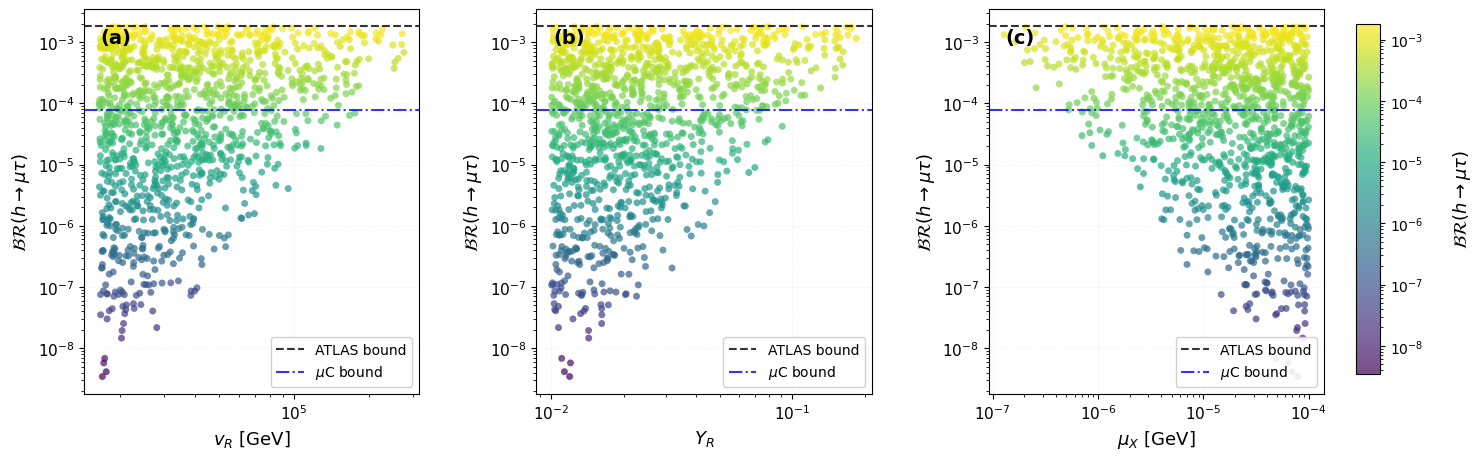


PARAMETER CORRELATION SUMMARY
Total allowed points: 1203
BR(h→μτ) range: [3.45e-09, 1.80e-03]
ATLAS-2023 bound: 1.80e-03

Points above ATLAS bound: 0 (0.0%)


In [29]:
# Journal-style figure: BR(h→μτ) correlation with vR, YR, and μX
# Three-panel publication-quality plot

if scan_results_log.size == 0:
    print("No allowed points to plot.")
else:
    # Extract data directly from scan_results_log
    vR_arr = scan_results_log['vR']
    YR_arr = scan_results_log['YR']
    muX_arr = scan_results_log['muX']
    BR_h_mutau_arr = scan_results_log['h_mutau']  # Use correct field name
    
    # Helper to safely retrieve experimental bounds (avoid KeyError)
    def get_bound(key, default=None):
        try:
            return h_mutau_calc.EXPERIMENTAL_BOUND['h_mutau'][key]
        except Exception:
            return default

    atlas_bound = get_bound('ATLAS-2023', None)
    muC_bound_htomutau = get_bound('muC', None)  # Changed variable name
    print(f"ATLAS bound for h→μτ: {atlas_bound}")
    print(f"μC bound for h→μτ: {muC_bound_htomutau}")

    # Create figure with 3 horizontal panels
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Set consistent color normalization for BR(h→μτ)
    norm = mpl.colors.LogNorm(vmin=max(BR_h_mutau_arr.min(), 1e-18), 
                              vmax=BR_h_mutau_arr.max())
    cmap = 'viridis' #'RdYlBu_r'  # Red-Yellow-Blue reversed (red=high, blue=low)
    
    # ------------------------------------------------------------------
    # Panel (a): BR vs vR
    # ------------------------------------------------------------------
    sc1 = axes[0].scatter(vR_arr, BR_h_mutau_arr, 
                          c=BR_h_mutau_arr, cmap=cmap, norm=norm,
                          s=25, alpha=0.7, edgecolor='none', rasterized=True)
    
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')
    axes[0].set_xlabel(r'$v_R$ [GeV]', fontsize=13)
    axes[0].set_ylabel(r'$\mathcal{BR}(h \to \mu\tau)$', fontsize=13)
    axes[0].grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    axes[0].tick_params(labelsize=11)
    axes[0].text(0.05, 0.95, '(a)', transform=axes[0].transAxes, 
                 fontsize=14, fontweight='bold', va='top')
    
    # Add experimental bound if available
    if atlas_bound is not None:
        axes[0].axhline(atlas_bound, color='black', linestyle='--', linewidth=1.5, 
                        label='ATLAS bound', alpha=0.8)
    if muC_bound_htomutau is not None:
        axes[0].axhline(muC_bound_htomutau, color='blue', linestyle='-.', linewidth=1.5, 
                        label=r'$\mu$C bound', alpha=0.8)
    axes[0].legend(loc='lower right', fontsize=10, framealpha=0.9)
    
    # ------------------------------------------------------------------
    # Panel (b): BR vs YR
    # ------------------------------------------------------------------
    sc2 = axes[1].scatter(YR_arr, BR_h_mutau_arr, 
                          c=BR_h_mutau_arr, cmap=cmap, norm=norm,
                          s=25, alpha=0.7, edgecolor='none', rasterized=True)
    
    axes[1].set_xscale('log')
    axes[1].set_yscale('log')
    axes[1].set_xlabel(r'$Y_R$', fontsize=13)
    axes[1].set_ylabel(r'$\mathcal{BR}(h \to \mu\tau)$', fontsize=13)
    axes[1].grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    axes[1].tick_params(labelsize=11)
    axes[1].text(0.05, 0.95, '(b)', transform=axes[1].transAxes, 
                 fontsize=14, fontweight='bold', va='top')
    
    # Add experimental bound if available
    if atlas_bound is not None:
        axes[1].axhline(atlas_bound, color='black', linestyle='--', linewidth=1.5, 
                        label='ATLAS bound', alpha=0.8)
    if muC_bound_htomutau is not None:
        axes[1].axhline(muC_bound_htomutau, color='blue', linestyle='-.', linewidth=1.5, 
                        label=r'$\mu$C bound', alpha=0.8)

    # Add perturbativity limit
    #axes[1].axvline(h_mutau_calc.YR_PERTURBATIVE_LIMIT, 
    #                color='purple', linestyle='-.', linewidth=1.5,
    #                label=r'$Y_R = \sqrt{6\pi}$', alpha=0.8)
    axes[1].legend(loc='lower right', fontsize=10, framealpha=0.9)
    
    # ------------------------------------------------------------------
    # Panel (c): BR vs μX
    # ------------------------------------------------------------------
    sc3 = axes[2].scatter(muX_arr, BR_h_mutau_arr, 
                          c=BR_h_mutau_arr, cmap=cmap, norm=norm,
                          s=25, alpha=0.7, edgecolor='none', rasterized=True)
    
    axes[2].set_xscale('log')
    axes[2].set_yscale('log')
    axes[2].set_xlabel(r'$\mu_X$ [GeV]', fontsize=13)
    axes[2].set_ylabel(r'$\mathcal{BR}(h \to \mu\tau)$', fontsize=13)
    axes[2].grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    axes[2].tick_params(labelsize=11)
    axes[2].text(0.05, 0.95, '(c)', transform=axes[2].transAxes, 
                 fontsize=14, fontweight='bold', va='top')
    
    # Add experimental bound if available
    if atlas_bound is not None:
        axes[2].axhline(atlas_bound, color='black', linestyle='--', linewidth=1.5, 
                        label='ATLAS bound', alpha=0.8)
    if muC_bound_htomutau is not None:
        axes[2].axhline(muC_bound_htomutau, color='blue', linestyle='-.', linewidth=1.5, 
                        label=r'$\mu$C bound', alpha=0.8)
    axes[2].legend(loc='lower right', fontsize=10, framealpha=0.9)
    
    # ------------------------------------------------------------------
    # Shared colorbar
    # ------------------------------------------------------------------
    # Add colorbar spanning all panels
    fig.subplots_adjust(right=0.90, wspace=0.35)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(sc1, cax=cbar_ax)
    cbar.set_label(r'$\mathcal{BR}(h \to \mu\tau)$', fontsize=13, rotation=90, labelpad=20)
    cbar.ax.tick_params(labelsize=10)
    
    # Overall title (optional - uncomment if needed for presentation)
    # fig.suptitle('Parameter Correlations with BR$(h \\to \\mu\\tau)$', 
    #              fontsize=15, fontweight='bold', y=0.98)
    
    plt.savefig('BR_h_mutau_correlations_journal.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('BR_h_mutau_correlations_journal.png', dpi=300, bbox_inches='tight')
    print("Saved: BR_h_mutau_correlations_journal.pdf and .png")
    
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*70)
    print("PARAMETER CORRELATION SUMMARY")
    print("="*70)
    print(f"Total allowed points: {len(vR_arr)}")
    print(f"BR(h→μτ) range: [{BR_h_mutau_arr.min():.2e}, {BR_h_mutau_arr.max():.2e}]")
    if atlas_bound is not None:
        print(f"ATLAS-2023 bound: {atlas_bound:.2e}")
        count_above = np.sum(BR_h_mutau_arr > atlas_bound)
        print(f"\nPoints above ATLAS bound: {count_above} ({count_above/len(vR_arr)*100:.1f}%)")
    else:
        print("ATLAS-2023 bound: N/A (not found in h_mutau_calc.EXPERIMENTAL_BOUND)")
    print("="*70)

In [38]:
vR_arr.max(), 2.7e5, 1e6

In [56]:
h_mutau_calc.EXPERIMENTAL_BOUND

{'h_emu': {'CMS-2023': 4.4e-05, 'HL-LHC': 1e-05, 'muC': 9.9e-06},
 'h_etau': {'ATLAS-2023': 0.002, 'HL-LHC': 0.0005, 'muC': 8.4e-05},
 'h_mutau': {'ATLAS-2023': 0.0018, 'HL-LHC': 0.0005, 'muC': 7.7e-05}}

muC bound on BR(h → μτ): 7.7e-05
MEG-II bound on BR(μ → eγ): 6e-14


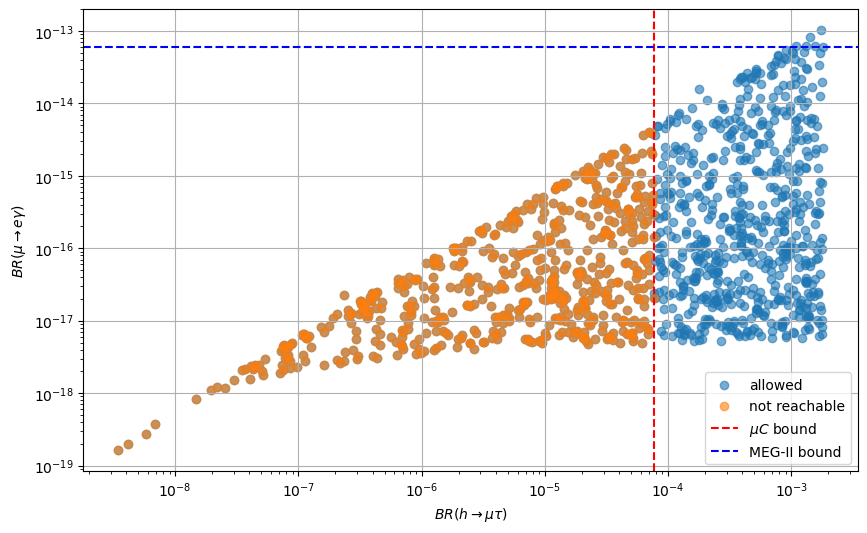

In [30]:
# Plot allowed points in plane BR(h → μτ) vs BR(μ → eγ)
import matplotlib.pyplot as plt

BR_h_mutau = structured_results['BR_h_mutau']
BR_meg = structured_results['BR_meg']

muC_bound_htomutau = h_mutau_calc.EXPERIMENTAL_BOUND['h_mutau']['muC']
MEG_II_meg_bound = mutoegamma_calc.EXPERIMENTAL_BOUND['mutoegamma']['MEG-II-future']
print(f"muC bound on BR(h → μτ): {muC_bound_htomutau}")
print(f"MEG-II bound on BR(μ → eγ): {MEG_II_meg_bound}")

# Create masks for projected and not reachable regions
#mask_proyected = (BR_h_mutau > muC_bound_htomutau) & (BR_meg > MEG_II_meg_bound)
mask_not_available = (BR_h_mutau <= muC_bound_htomutau) & (BR_meg <= MEG_II_meg_bound)

plt.figure(figsize=(10, 6))
plt.scatter(BR_h_mutau, BR_meg, alpha=0.6, label='allowed')
#plt.scatter(BR_h_mutau[mask_proyected], BR_meg[mask_proyected], alpha=0.6, label='projected')
plt.scatter(BR_h_mutau[mask_not_available], BR_meg[mask_not_available], alpha=0.6, label='not reachable')

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$BR(h \to \mu\tau)$")
plt.ylabel(r"$BR(\mu \to e \gamma)$")
plt.axvline(muC_bound_htomutau, color='red', ls='--', label=r"$\mu C$ bound")
plt.axhline(MEG_II_meg_bound, color='blue', ls='--', label='MEG-II bound')
#plt.title(r"Allowed Points: $BR(h \to \mu\tau)$ vs $BR(\mu \to e \gamma)$")
plt.grid()
plt.legend()
plt.show()